# Assignment 3

Kaylee Molin (22734429)

---

## Imports

In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import random
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_curve, silhouette_score, silhouette_samples
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from pathlib import Path
from graphviz import Source
import matplotlib.patches as patches  # extra code – for the curved arrow
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster
import matplotlib.cm as cm
import seaborn as sns

## Part 1: A model for diagnosing cancer

**Defining the functions to be used in this question.**

---
Task 1 functions:

In [20]:
def plot_pairplot(df, target_col, feature_cols):
    '''Plot a pairplot with modified legend labels'''
    g = sns.pairplot(df, hue=target_col, vars=feature_cols, corner=True)
    g._legend.set_title('Class')
    plt.show()
    return g

In [21]:
def plot_heatmap(corr_matrix, figsize=(20,20)):
    '''plot heatmap using a correaltion matrix'''
    plt.figure(figsize=figsize)
    heatmap = sns.heatmap(corr_matrix, cmap="coolwarm", annot=True)
    print(heatmap)
    plt.show()   

In [22]:
def drop_features(df, feature_list):
    '''Drop features from specified dataframe'''
    return df.drop(feature_list, axis=1)

In [23]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(corr_matrix, n=10):
    '''Get top correlated pairs of features'''
    au_corr = corr_matrix.abs().unstack()
    labels_to_drop = get_redundant_pairs(corr_matrix)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

In [24]:
def split_Xy(data, target_name):
    X = data.iloc[:, :-1]
    y = data[target_name]
    return X, y

In [25]:
def preprocess_data(data, target_name, test_size=0.15):
    '''Split data in the X_train, X_test, y_train, y_test and scale'''
    X, y = split_Xy(data, target_name)

    # Split the data into training and testing sets with 85% for training and 15% for testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=123)

    # Scaling the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Convert X_train and X_test back to a pandas dataframe
    X_train = pd.DataFrame(X_train, columns=X.columns)
    X_test = pd.DataFrame(X_test, columns=X.columns)
    
    return X_train, X_test, y_train, y_test
    

In [26]:
def plot_bar_graph(accuracy_train, accuracy_test, title, xtitle=['Training Set', 'Test Set'], ylabel='Accuracy'):
    '''Plots a bar graph with 2 columns'''
    colors = ['Lightgray', 'Gray']

    plt.bar(xtitle, [accuracy_train, accuracy_test], color=colors)
    plt.title(title)
    plt.ylabel(ylabel)

    for i, v in enumerate([accuracy_train, accuracy_test]):
        plt.text(i, v + 0.01, str(round(v, 4)), color='black', ha='center')

    plt.show()
   

In [27]:
def get_best_clf(clf, param_grid, X_train, y_train, X_test, y_test, model_name):
    # Create the cross-validator object with random_state
    cv = KFold(n_splits=3, random_state=21, shuffle=True)

    # Perform grid search to find the best hyperparameters
    grid_search = GridSearchCV(clf, param_grid, cv=cv)
    grid_search.fit(X_train, y_train)

    # Print the best hyperparameters found
    print("Best Hyperparameters:", grid_search.best_params_)

    # Train the decision tree classifier with the best hyperparameters
    best_model = grid_search.best_estimator_
    best_model.fit(X_train, y_train)

    # Evaluate the model on the training set
    accuracy_train = best_model.score(X_train, y_train)
    print("\nAccuracy of the {} model (training): {:.2f}%".format(model_name, accuracy_train * 100))

    # Evaluate the model on the test set
    accuracy_test = best_model.score(X_test, y_test)
    print("Accuracy of the {} model (testing): {:.2f}%".format(model_name, accuracy_test * 100))


    return accuracy_train, accuracy_test, best_model


In [28]:
def plot_side_by_side(x_titles, accuracies_train, accuracies_test, rotate=45, title1='Training Set Accuracies', title2='Testing Set Accuracies', ylabel='Accuracies',ylim=1.05):
    '''Plots 2 bar graphs side-by-side'''
    colors = ['pink', 'lavender', 'lightblue', 'palegreen', 'yellow']
    
    fig, axes = plt.subplots(1, 2, figsize=(10,5))
    axes[0].bar(x_titles, accuracies_train, color=colors)
    axes[0].set_title(title1)
    axes[0].set_ylabel(ylabel)
    axes[0].tick_params(axis='x', labelrotation=rotate) # rotate x-tick labels
    axes[0].set_ylim([0, ylim])
    for i, v in enumerate(accuracies_train):
        axes[0].text(i, v + 0.01, str(round(v, 4)), color='black', ha='center')

    # Plot the testing set accuracies
    axes[1].bar(x_titles, accuracies_test, color=colors)
    axes[1].set_title(title2)
    #axes[1].set_ylabel('Accuracy')
    axes[1].tick_params(axis='x', labelrotation=rotate) # rotate x-tick labels
    axes[1].set_ylim([0, ylim])
    for i, v in enumerate(accuracies_test):
        axes[1].text(i, v + 0.01, str(round(v, 4)), color='black', ha='center')

    # Display the plots
    plt.show()

In [29]:
def plot_confusion_matrix(y_test, y_test_pred, label, ax):
    # Calculate the confusion matrix for the test set
    cm_best = confusion_matrix(y_test, y_test_pred)

    # Extract TN, FP, FN, TP values from the confusion matrix
    tn_best, fp_best, fn_best, tp_best = cm_best.ravel()

    # Plot the confusion matrix
    sns.heatmap(cm_best, annot=True, fmt='d', cmap="Purples", annot_kws={"size": 18},
                cbar=False, square=True, xticklabels=['Predicted: M', 'Predicted: B'], 
                yticklabels=['Actual: M', 'Actual: B'], ax=ax)
    ax.text(0.5, 1.1, f"TN={tn_best}\nFP={fp_best}\nFN={fn_best}\nTP={tp_best}", 
    fontsize=12, ha="center", transform=ax.transAxes)
    ax.set_xlabel("Predicted labels")
    ax.set_ylabel("True labels")
    ax.set_title(str(label))
    
    return tn_best, fp_best, fn_best, tp_best


In [30]:
def plot_precision_recall(y_test, y_test_pred, label):
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_test_pred)

    idx = (thresholds >= 0.5).argmax()  # first index ≥ threshold

    plt.plot(recalls, precisions, '--', linewidth=2, label="Precision/Recall curve for "+label)

    # extra code – just beautifies and saves Figure 3–6
    #plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
    #plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
    #plt.plot([recalls[idx]], [precisions[idx]], "ko",
             #label="Point at threshold 0.5")
    plt.gca().add_patch(patches.FancyArrowPatch(
        (0.79, 0.60), (0.61, 0.78),
        connectionstyle="arc3,rad=.2",
        arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
        color="#444444"))
    plt.text(0.56, 0.82, "Higher\nthreshold", color="#333333")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.axis([0, 1.01, 0.5, 1.01])
    plt.grid()
    plt.legend(loc="lower left")

    #plt.show()


In [31]:
def plot_with_threshold(y_test, y_pred, title, threshold=0.5):
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred)

    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.vlines(threshold, 0, 1.2, "k", "dotted", label="Threshold")

    idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
    plt.axis([0, 1, 0, 1.1])
    plt.grid()
    plt.title(title)
    plt.ylabel("Value")
    plt.xlabel("Threshold")
    plt.legend(loc="center right")

---
Task 2 functions:


In [32]:
def plot_feature_importance(trained_model, data, title, threshold=0.05):
    if hasattr(trained_model, 'feature_importances_'):
        # Decision Tree or Random Forest
        importances = trained_model.feature_importances_
        sorted_idx = importances.argsort()
        plt.barh(range(len(importances)), importances[sorted_idx])
        for i, v in enumerate(importances[sorted_idx]):
            plt.text(v + 0.01, i, str(round(v, 3)))
        plt.yticks(range(len(importances)), data.columns[sorted_idx])
        plt.xlabel('Feature Importance')
    elif hasattr(trained_model, 'coef_'):
        # Logistic Regression
        coefficients = np.abs(trained_model.coef_[0])
        coef_sum = np.sum(coefficients)
        coefficients = coefficients/coef_sum
        sorted_idx = np.abs(coefficients).argsort()
        plt.barh(range(len(coefficients)), coefficients[sorted_idx])
        for i, v in enumerate(coefficients[sorted_idx]):
            plt.text(v + 0.01, i, str(round(v, 3)))
        plt.yticks(range(len(coefficients)), data.columns[sorted_idx])
        plt.xlabel('Absolute Coefficient')
    else:
        raise ValueError('The model does not support feature importances or coefficients.')
    
    plt.title(title)
    plt.show()


---
Task 3 functions:


In [33]:
def pca_plot(X_pca, pca, y):

    # Calculate the variance ratio explained by the first two principal components
    variance_ratio = pca.explained_variance_ratio_

    cmap = ListedColormap(['hotpink', 'cornflowerblue'])

    # Create a scatter plot of the data on the first two principal components
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap=cmap, alpha=0.5)
    plt.xlabel('1st Principal Component')
    plt.ylabel('2nd Principal Component')
    plt.title('PCA Scatter Plot of Breast Cancer Dataset')

    # force the ticks
    cb = plt.colorbar(ticks=[0.25,.75])
    cb.set_ticklabels([0,1])
    cb.ax.set_yticklabels(['0 - Benign', '1 - Malignant'])
    plt.show()

    print(f"Proportion of data variance explained by the first two principal components: {sum(variance_ratio):.2f}")


In [34]:
def pca_plot_biplot(X_pca, feature_names, y, pca):

    cmap = ListedColormap(['hotpink', 'cornflowerblue'])
    
    # Create a biplot with variable vectors
    fig, ax = plt.subplots(figsize=(10, 8))
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap=cmap, alpha=0.5)

    # Plot variable vectors with loadings and longer lines
    feature_vectors = pca.components_.T * np.sqrt(pca.explained_variance_)
    for i, feature in enumerate(feature_names):
        loadings_text = f'{feature} ({feature_vectors[i, 0]:.2f}, {feature_vectors[i, 1]:.2f})'
        ax.arrow(0, 0, feature_vectors[i, 0]*4, feature_vectors[i, 1]*4, color='black', alpha=0.7, linewidth=2)
        ax.text(feature_vectors[i, 0] * 4.2, feature_vectors[i, 1] * 4.2, loadings_text, color='black', fontweight='bold')

    ax.set_xlabel('1st Principal Component')
    ax.set_ylabel('2nd Principal Component')
    ax.set_title('Biplot of Data on the First Two Principal Components')

    ax.axhline(0, color='black', linewidth=0.5)
    ax.axvline(0, color='black', linewidth=0.5)

    cbar = plt.colorbar(scatter, ax=ax, ticks=[0.25, 0.75])
    cbar.set_ticklabels([0, 1])
    cbar.ax.set_yticklabels(['0 - Benign', '1 - Malignant'])

    plt.show()


---
Task 5 functions:


In [35]:
def get_num_comps(X, variance_limit=0.95):
    n_components=X.shape[1]
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)

    explained_variance_ratio = pca.explained_variance_ratio_

    # Calculate the cumulative explained variance ratio
    explained_variance_ratio_cumulative = np.cumsum(explained_variance_ratio)

    # Find the number of components to retain 95% of the explained variance
    num_components = np.argmax(explained_variance_ratio_cumulative >= variance_limit) + 1

    # Print the explained variance ratio of each component
    for i, ratio in enumerate(explained_variance_ratio):
        print(f"Component {i+1}: Explained Variance Ratio = {ratio:.4f}")

    # Print the components contributing to 95% of the explained variance
    print(f"\nComponents contributing to at least {variance_limit*100:.0f}% of the explained variance: {num_components}")
    print(f"\nVariance retained using {num_components} components: {100*explained_variance_ratio_cumulative[num_components-1]:.2f}%")
    return num_components

## Part  - Task 1

In [36]:
# Importing the data
cancer_data = pd.read_csv("breast-cancer.csv")

# Viewing the data to look at the features
cancer_data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883


> The "id" column is unnecessary in the model and will be removed. The "diagnosis" column will be set as the target. The 'M' and the 'B' labels will be replaced with 1 and 0 respectively.

In [37]:
# Removing the "id" column
cancer_data = drop_features(cancer_data, "id")

# Setting 'M' -> 1 and 'B' -> 0
cancer_data['diagnosis'] = cancer_data['diagnosis'].replace({'M': 1, 'B': 0})

**Viewing correlation between features for feature reduction and to simplify the model** get rid of fix

In [38]:
# corr_matrix_cancer = cancer_data.corr()

# # plot correlation matrix using heatmap
# plot_heatmap(corr_matrix_cancer)

In [39]:
# top_corr = get_top_abs_correlations(corr_matrix_cancer, 10)

# print("Top Absolute Correlations\n")
# print(top_corr)

> There are many highly correalted features. Redundant features can introduce unnecessary complexity to the model and potentially lead to overfitting. Removing these correlated features can help with:

>1. Multicollinearity: Highly correlated features often exhibit multicollinearity, which means they provide similar information to the model. When multicollinearity is present, it becomes difficult for the model to discern the individual contribution of each feature, potentially leading to unstable and unreliable results.

>2. Simplifying the model: By removing redundant features, you simplify the model and reduce its complexity. It becomes easier to understand the impact of each remaining feature on the model's predictions and reduces computational time.

>3. Better generalisation: Removing redundant features can help prevent overfitting. By reducing the number of correlated features, the model focuses on the essential information, allowing it to generalise better and make more accurate predictions on unseen data.

> I will be removing features have a correlation greater than 0.9.



In [40]:
# Dropping highly corealted features
#cancer_data_dropped = drop_features(cancer_data, ["concave points_mean", "area_mean", "perimeter_mean"])

In [41]:
# corr_matrix_cancer_dropped = cancer_data_dropped.corr()

# # plot correlation matrix using heatmap
# plot_heatmap(corr_matrix_cancer_dropped)

> As seen in the above correlation matrix, all correlations above 0.9 have now been removed.

**Determining the size of the dataset and if it is balanced or not.**

In [42]:
# cancer_data_dropped.shape

> The Wisconsin Breast Cancer dataset contains a total of 569 samples, which is relatively small in terms of sample size. When building a model for predicting cancer diagnosis, it is crucial to have both high accuracy and high sensitivity. Given the limited size of this dataset, it may pose challenges in achieving the necessary model performance. 

In [43]:
# Count number of instances for each class label
#diagnosis_counts = cancer_data_dropped['diagnosis'].value_counts()

diagnosis_counts = cancer_data['diagnosis'].value_counts()

print(diagnosis_counts)

0    357
1    212
Name: diagnosis, dtype: int64


> This dataset is imbalanced, with 357 benign diagnoses and 212 malignant diagnoses. The dataset is skewed towards the benign class. Imbalanced datasets can affect the model's ability to accurately predict the minority class (in this case, malignant samples). Since the number of malignant samples is relatively smaller, the model may tend to favor predicting the majority class (benign) more frequently. This needs to be considered when assessing the model's performance.

**Scaling the data and preprocessing it**

In [44]:
# Move 'diagnosis' column to the end
#cancer_data_dropped = cancer_data_dropped.reindex(columns=[col for col in cancer_data_dropped.columns if col != 'diagnosis'] + ['diagnosis'])
#cancer_data_dropped.head()


# NON DROPPED
cancer_data= cancer_data.reindex(columns=[col for col in cancer_data.columns if col != 'diagnosis'] + ['diagnosis'])

In [45]:
#X_train, X_test, y_train, y_test = preprocess_data(cancer_data_dropped, 'diagnosis')

X_train, X_test, y_train, y_test = preprocess_data(cancer_data, 'diagnosis', test_size=0.2)

> The dataset contains only 569 samples. Therefore, a 20% test size is chosen because it allows for a reasonable evaluation while still preserving a sufficient number of samples for training and validation purposes.

### Building a logistic regression model

**Using Grid search and cross validation (implemented within `get_best_clf`) to find the best hyperparameters for the model**

In [46]:
logreg = LogisticRegression()

param_grid_lr = {
    'C': [100, 10, 1.0, 0.1, 0.01],
    'penalty': ['l1', 'l2'],
    'class_weight': ['balanced', None],
    'solver': ['liblinear', 'saga'], 
    'max_iter': [10000]
}

accuracy_train_lr, accuracy_test_lr, best_lr = get_best_clf(logreg, param_grid_lr, X_train, y_train, X_test, y_test, 'logistic regression')

Best Hyperparameters: {'C': 0.1, 'class_weight': None, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'saga'}

Accuracy of the logistic regression model (training): 93.63%
Accuracy of the logistic regression model (testing): 95.61%


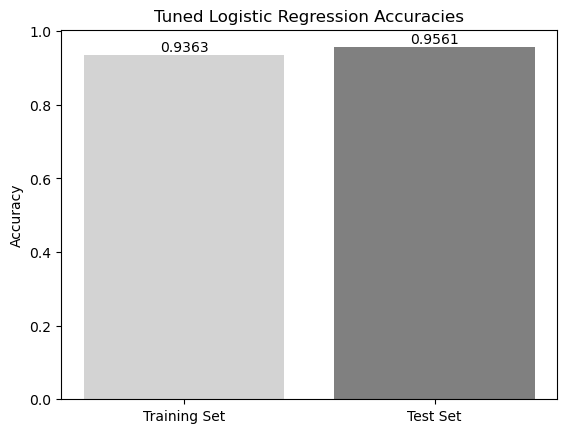

In [47]:
plot_bar_graph(accuracy_train_lr, accuracy_test_lr, 'Tuned Logistic Regression Accuracies')

The parameters `C`, `penalty`, `class_weight` and `solver` were used in this grid search to explore a range of possible values and combinations that could potentially optimise the performance of the model.

* The `C` parameter represents the inverse of regularisation strength. Higher values of `C` correspond to less regularisation, allowing the model to potentially fit the training data more closely.
* The `penalty` parameter determines the type of regularisation used (L1 or L2 which correspond with Lasso and Ridge regression respectively).
* The `class_weight` parameter is used with `balanced` and `None` options to handle class imbalance in the dataset. This dataset is imbalanced, hence may be necessary to use this paramter. It allows the model to assign different weights to different classes during training to more fairly representat the classes leading to more accurate predictions.
The `solver` parameter offers different algorithms to solve the optimisation problem. `liblinear` and `saga` are selected.

> As seen in the above accuracy plot, the Logistic Regression model performs very well on both the testing and training sets, with accuracies above 93% for both. This may suggest that the Logistic Regression model is well suited for this problem. However, it is important to assess the model in a variety of ways before making conclusion on its suitability.

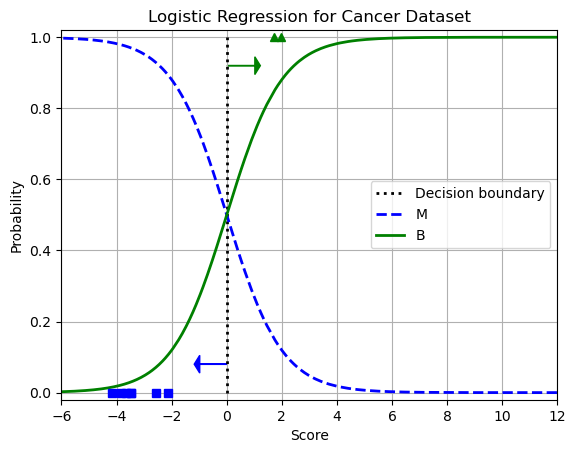

Decision boundary for the logistic regression model: 0.01992


In [48]:
# Extract the terms from the trained logistic regression model
weights = best_lr.coef_
bias = best_lr.intercept_

# Compute the dot product of input data with the transposed weights and add the bias term
dots = np.dot(X_train, np.transpose(weights)) + bias

## Predict the class probabilities using the logistic regression model
y_axis = best_lr.predict_proba(X_train)

# Sort the dot product values and corresponding class probabilities
dots_sorted, y_sorted = zip(*sorted(zip(dots, y_axis)))

# Extract the decision boundary
decision_boundary = np.array(dots_sorted)[np.array(y_sorted)[:, 1] >= 0.5][0, 0]

plt.plot([decision_boundary, decision_boundary], [0, 1], "k:", linewidth=2, label="Decision boundary")
plt.title("Logistic Regression for Cancer Dataset")
plt.plot(dots_sorted, np.array(y_sorted)[:, 0], "b--", linewidth=2, label="M")
plt.plot(dots_sorted, np.array(y_sorted)[:, 1], "g-", linewidth=2, label="B") 

plt.arrow(x=decision_boundary, y=0.08, dx=-1, dy=0, head_width=0.05, head_length=0.2, fc="b", ec="b")
plt.arrow(x=decision_boundary, y=0.92, dx=1, dy=0, head_width=0.05, head_length=0.2, fc="g", ec="g")
plt.legend(loc="center right")

# Retrieving 10 random instances to plot from the testing set
random.seed(21)
random_indices = np.sort(np.array([random.randint(0, len(X_test)) for _ in range(10)]))

dots_testing = (np.dot(X_test, np.transpose(weights)) + bias)[random_indices]
y_axis_testing = (best_lr.predict_proba(X_test))[random_indices]
y_axis_proba = (best_lr.predict(X_test))[random_indices]
plt.xlabel("Score")
plt.ylabel("Probability")
plt.grid()

s=y_axis_testing[:,0]
d=y_axis_testing[:,1]
plt.axis([-6, 12, -0.02, 1.02]) # [x left lim, x right lim, y lower lim, y upper lim]

plt.plot(dots_testing[y_axis_proba == 0], y_axis_proba[y_axis_proba == 0], "bs")
plt.plot(dots_testing[y_axis_proba == 1], y_axis_proba[y_axis_proba == 1], "g^")

plt.legend()
plt.show()

print(f"Decision boundary for the logistic regression model: {decision_boundary:.5f}")

> The decision boundary is very close to 0 which can be advantageous. This is because the dataset aims to classify tumours as either malignant or benign based on various features. A decision boundary near 0 indicates that the model is making predictions based on a subtle balance between the two classes, potentially leading to more accurate and precise classifications.

### Building a decision tree

In [49]:
dtree = DecisionTreeClassifier()

param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

accuracy_train_dt, accuracy_test_dt, best_dt = get_best_clf(dtree, param_grid_dt, X_train, y_train, X_test, y_test, 'decision tree')

Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}

Accuracy of the decision tree model (training): 97.80%
Accuracy of the decision tree model (testing): 91.23%


In [50]:
IMAGES_PATH = Path() / "images"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        pltbefig(path, format=fig_extension, dpi=resolution)

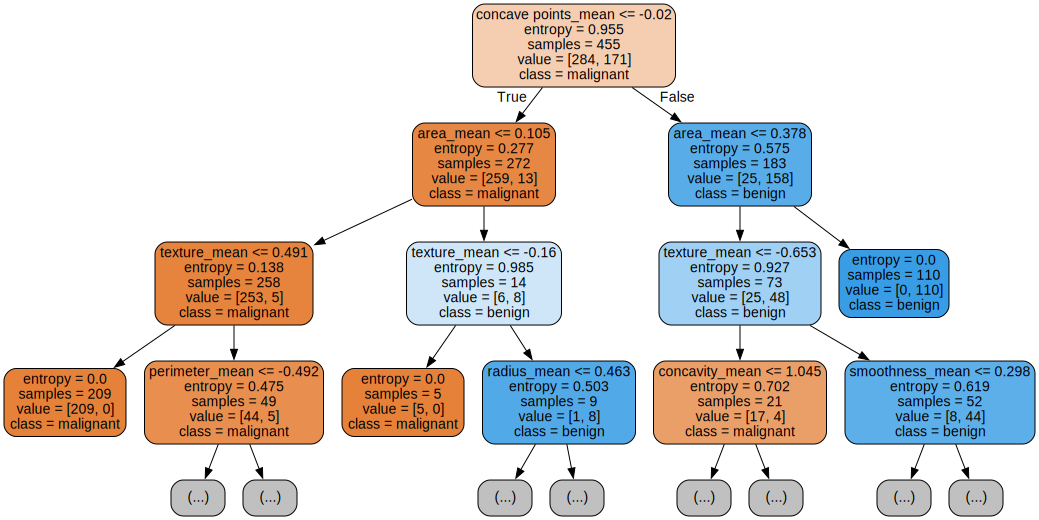

In [51]:
export_graphviz(
        best_dt,
        out_file=str(IMAGES_PATH / "tree.dot"), 
        feature_names=list(X_train.columns),
        class_names=['malignant', 'benign'],
        rounded=True,
        filled=True,
    	max_depth=3
    )

Source.from_file(IMAGES_PATH / "tree.dot")


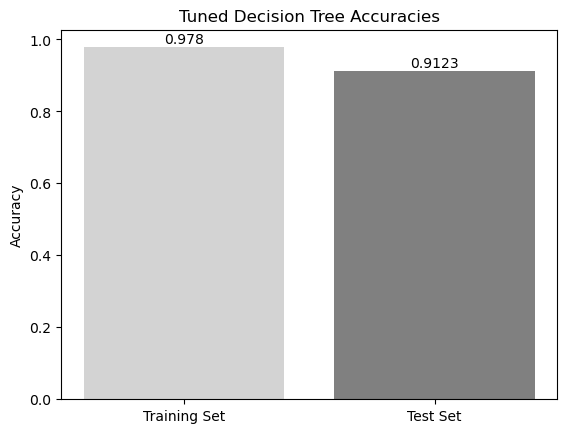

In [52]:
plot_bar_graph(accuracy_train_dt, accuracy_test_dt, 'Tuned Decision Tree Accuracies')

The parameters `criterion`, `max_depth`, `min_samples_split` and `min_samples_leaf` were used in this grid search to explore a range of possible values and combinations that could potentially optimise the performance of the model.

* The `criterion`: [`gini`, `entropy`]: The criterion parameter determines the quality of a split in the decision tree. By including both `gini` and `entropy`, we assess two commonly used metrics for measuring impurity, enabling us to compare their performance and select the better criterion.

`max_depth`: [None, 5, 10, 15]: The max_depth parameter defines the maximum depth of the decision tree. This allows us to avoid overfitting or underfitting and find an appropriate depth that balances complexity and performance.

`min_samples_split`: [2, 5, 10]: The min_samples_split parameter sets the minimum number of samples required to split an internal node.

`min_samples_leaf`: [1, 2, 4]: The min_samples_leaf parameter specifies the minimum number of samples required to be at a leaf node. 

> The accuracy of the decision tree model on the training set was very high at aroung 98%, indicating a strong ability to fit the training data. On the testing set, the model achieved an accuracy of around 90%. It is possible that this model is overfitting to the training data as seen by the high trainig set accuracy and lower testing set accuracy. Also, looking at the decision tree, some nodes have an entropy of 0 indicating a perfect separation of the data, which could suggest potential overfitting.

### Comparing the Logisitc Regression Model with the Decision Tree Classifier

**Comparison of Accuracies**

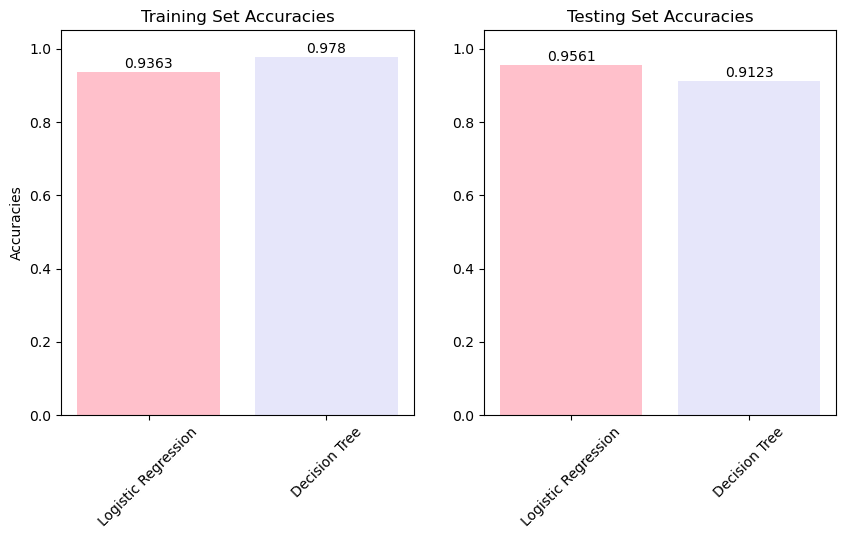

In [53]:
plot_side_by_side(['Logistic Regression', 'Decision Tree'], [accuracy_train_lr, accuracy_train_dt], [accuracy_test_lr, accuracy_test_dt])

**Comparison of Confusion Matrices**

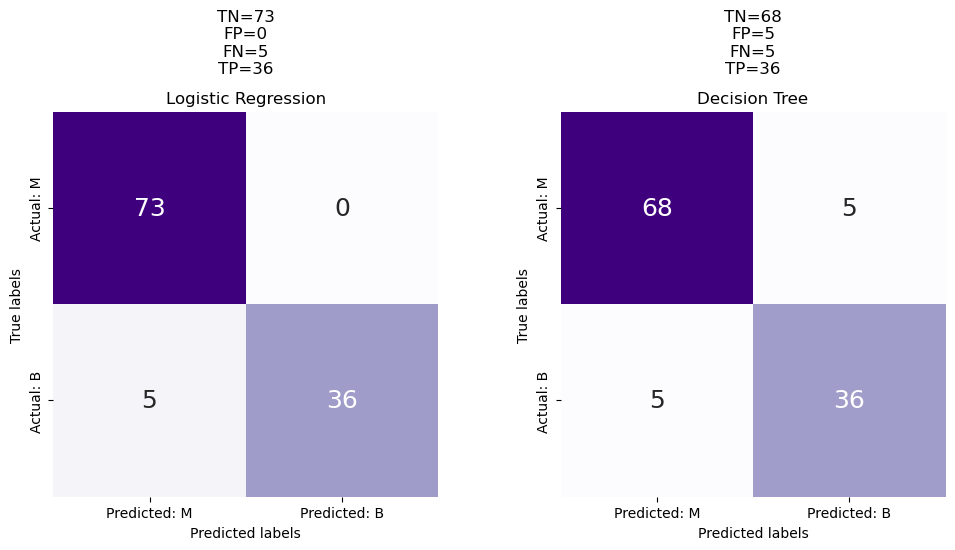

In [54]:
y_pred_lr = best_lr.predict(X_test)
y_pred_dt = best_dt.predict(X_test)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # Modified line: 1 row, 2 columns

tn_best_default, fp_best_default, fn_best_default, tp_best_default = plot_confusion_matrix(y_test, y_pred_lr, "Logistic Regression", axs[0])
tn_best_depth, fp_best_depth, fn_best_depth, tp_best_depth = plot_confusion_matrix(y_test, y_pred_dt, "Decision Tree", axs[1])

#plt.tight_layout()
plt.show()

**Comparison Precision/Recall Curves**

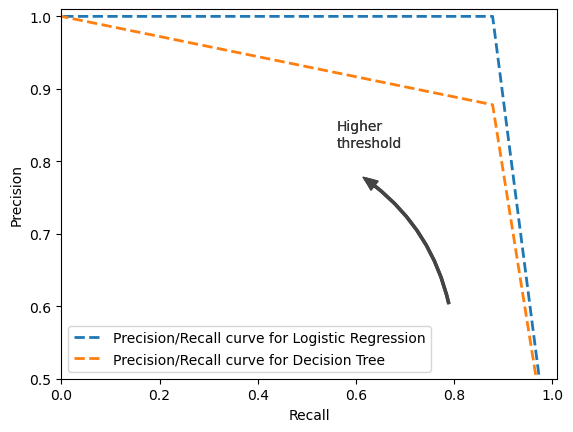

In [55]:
plot_precision_recall(y_test, y_pred_lr, "Logistic Regression")
plot_precision_recall(y_test, y_pred_dt, "Decision Tree")

plt.show()

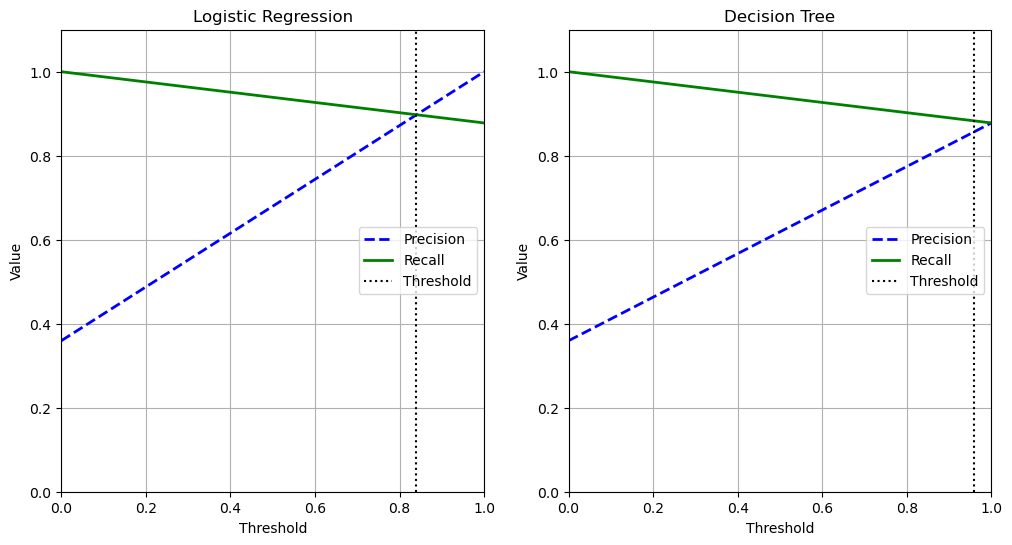

In [56]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first subplot
plt.sca(axes[0])
plot_with_threshold(y_test, y_pred_lr, "Logistic Regression", threshold=0.84)

# Plot the second subplot
plt.sca(axes[1])
plot_with_threshold(y_test, y_pred_dt, "Decision Tree", threshold=0.96)

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.2)

# Show the figure
plt.show()


> Based on the accuracy on both the training and testing datasets, logistic regression achieved higher accuracy compared to the decision tree. Logistic regression achieved an accuracy of 0.9561 on the testing dataset, while the decision tree achieved an accuracy of 0.9123. Considering the nature of a clinical setting where accurate predictions are crucial, logistic regression's higher accuracy suggests that it may be more appropriate for this particular scenario.

> Looking at the confusion matrices, logistic regression has fewer false positives (FP=0) compared to the decision tree (FP=5), indicating that logistic regression may be better at minimising false positive predictions, which can be particularly important in a clinical setting where minimising false positives is often desired. This would decrease the number of unnecessary treatments.

> The precision-recall curve also shows a higher precision for logistic regression. This indicates that logistic regression may have a better ability to correctly identify positive cases (higher precision) compared to the decision tree.

> Considering all these factors, it is recommended to use logistic regression in this clinical setting due to its higher accuracy, lower false positive rate, and higher precision. However, specific clinical requirements and computational power should be considered when making a final selection.

FIX speak about how we dont want any false negatices 

## Part 1 - Task 2

**Feature importance for the Logistic Regression model**

The coefficients of the features are used to deduce feature importance for the logisitc regression model. The absolute values of the coefficients are used in this plot and are scaled down so they sum to 1.

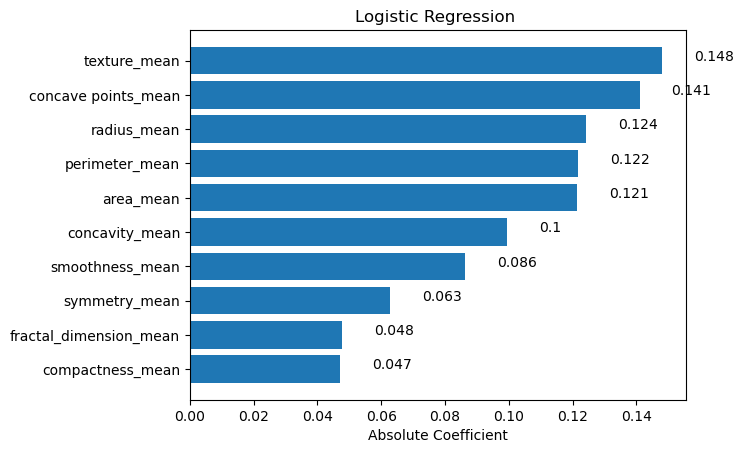

In [57]:
plot_feature_importance(best_lr, cancer_data, "Logistic Regression ")

**Feature importance for the Decision Tree model**

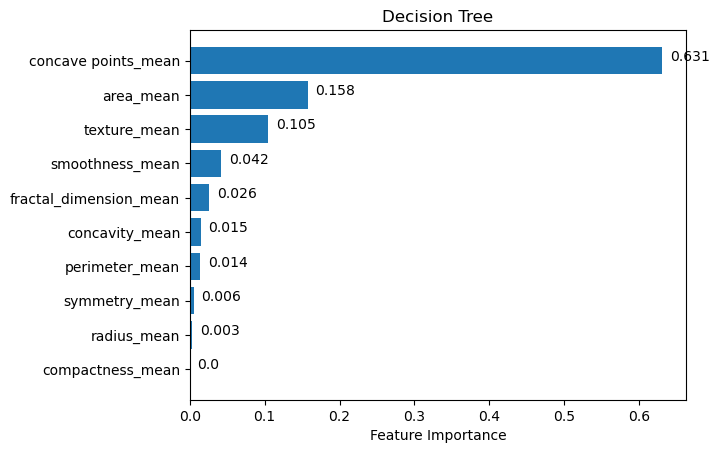

In [58]:
plot_feature_importance(best_dt,cancer_data, "Decision Tree")

**Discussion about feature importances**

> Both models exhibit relatively similar levels of feature importance. Both models identify `concave_points_mean` as a highly important feature. On the other hand, `compactness_mean` and `symmetry_mean` are considered less significant in both models.

> However, an interesting observation is the varying importance attributed to `radius_mean` between the two models. `radius_mean` displays a strong correlation with `area_mean`. The decision tree model seems to incorporate `area_mean` into its model, which potentially explains the relatively lower importance assigned to `radius_mean` due to redundancy.

> This fairly high level of consistency in feature importance is reassuring, as it suggests that these particular features consistently hold valuable information for tumour status prediction. Therefore, they should be given significant consideration when interpreting the models and making decisions based on their outputs.

## Part 1 - Task 3

**Creating a scatter plot of the data using the first 2 principle components using PCA**

In [59]:
# No longer using testing and training set in PCA
X = cancer_data.iloc[:, 0:-1]
y = cancer_data.iloc[:, -1]

# Scaling the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


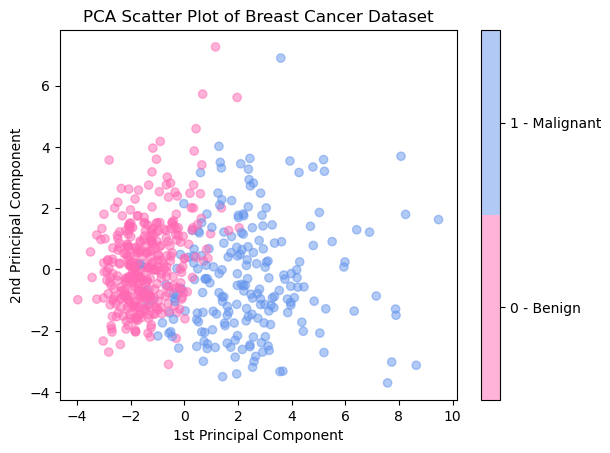

Proportion of data variance explained by the first two principal components: 0.80


In [60]:
# Defining the PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plotting the PCA
pca_plot(X_pca, pca, y)

> The first and second principle components make up 80% of the variance in the data.

## Part 1 - Task 4 & 5

**Creating a biplot with the variables vectors and the observed data projected on the first two principal components**

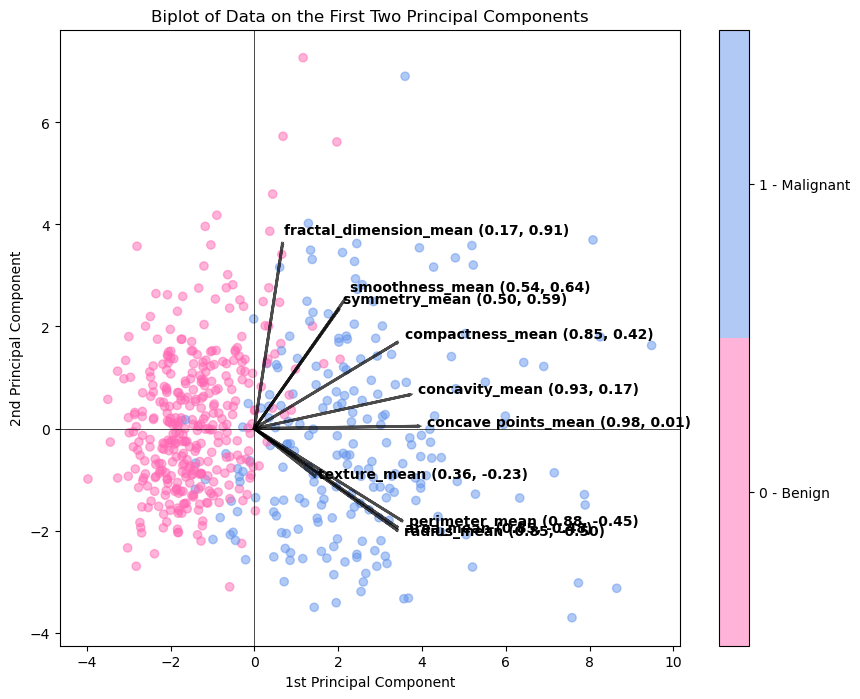

In [61]:
feature_names = cancer_data.columns[0:-1]

pca_plot_biplot(X_pca, feature_names, y, pca)

> The PCA plot of the dataset reveals important features about the data. Firstly, there is a clear separation between the benign and malignant samples, with many benign samples clustering on the negative side of the 1st principal component, while numerous malignant instances are concentrated on the positive end. A decision boundary can be placed between the two classes. The 1st principle component hold most of the variance of the data, hence, is more importance to the categorisation of the data,

> Perpendicular to this decision boundary, there is a collection of overlapping features, `perimeter_mean`, `area_mean`, and `radius_mean`. These features are highly correlated due to the circular nature of the cell's nucleus. The PCA plot confirms this correlation, as they exhibit similar loadings. The `texture_mean` feature also aligns with the same direction, but with a lower loading, indicating its relatively lower importance. The direction of these four features suggests a fairly strong correlation between them and the classification of instances, as they are perpendicular to the decision boundary. Also, a significant proportion of their direction lies within the 1st principal component, which accounts for a larger portion of the variance compared to the y-direction (2nd principal axis).

> On the other hand, `concave_points_mean`, `concavity_mean`, and `compactness_mean` show the largest component in the direction of the 1st principal component. This indicates their high importance in categorising the instances.

> In the direction of the decision boundary, we observe features such as `fractal_dimension_mean`, `smoothness_mean`, and `symmetry_mean`. These features have larger components in the y-direction, indicating their lesser importance compared to the previously discussed features. Moreover, since they align with the decision boundary direction, they do not provide significant valuable information for the classification.

> Comparing the "important" features we discussed (`concave_points_mean`, `concavity_mean`, and `compactness_mean`), the fairly important features (`perimeter_mean`, `area_mean`, `radius_mean`, and `texture_mean`), and the "unimportant features" (`fractal_dimension_mean`, `smoothness_mean`, and `symmetry_mean`) with the feature importances observed in Task 2, we notice many similarities. The general order of features remains consistent. This indicates that PCA is effective in providing valuable information about features in a dataset.> 

## Part 1 - Task 6

**Determining the number of features to retain 95% variance**

In [62]:
num_components = get_num_comps(X_scaled)

Component 1: Explained Variance Ratio = 0.5479
Component 2: Explained Variance Ratio = 0.2519
Component 3: Explained Variance Ratio = 0.0881
Component 4: Explained Variance Ratio = 0.0499
Component 5: Explained Variance Ratio = 0.0373
Component 6: Explained Variance Ratio = 0.0124
Component 7: Explained Variance Ratio = 0.0080
Component 8: Explained Variance Ratio = 0.0035
Component 9: Explained Variance Ratio = 0.0011
Component 10: Explained Variance Ratio = 0.0000

Components contributing to at least 95% of the explained variance: 5

Variance retained using 5 components: 97.49%


**Now using 5 features for PCA and repeating task 1**

In [130]:
# Retain the desired number of components
pca5 = PCA(n_components=num_components)
#X_pca5 = pca5.fit_transform(X_train)

X_train_PCA = pca5.fit_transform(X_train)
X_test_PCA = pca5.transform(X_test)

log_reg_PCA = LogisticRegression()

log_reg_PCA.fit(X_train_PCA, y_train)
y_pred_test_PCA = log_reg_PCA.predict(X_test_PCA)
y_pred_train_PCA = log_reg_PCA.predict(X_train_PCA)

accuracy_test_lr_PCA = accuracy_score(y_test, y_pred_test_PCA)
accuracy_train_lr_PCA = accuracy_score(y_train, y_pred_train_PCA)

###############################

param_grid_lr = {
    'C': [100, 10, 1.0, 0.1, 0.01],
    'penalty': ['l1', 'l2'],
    'class_weight': ['balanced', None],
    'solver': ['liblinear', 'saga'], 
    'max_iter': [10000]
}

accuracy_train_lr_PCA, accuracy_test_lr_PCA, best_lr_PCA = get_best_clf(log_reg_PCA, param_grid_lr, X_train_PCA, y_train, X_test_PCA, y_test, model_name='logistic regression')

# X_pca5 contains the new projected data set with reduced dimensionality

# Split the PCA-transformed data into training and testing sets
#X_train_PCA, X_test_PCA, y_train_PCA, y_test_PCA = train_test_split(X_pca5, y, test_size=0.2, random_state=123)



Best Hyperparameters: {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 10000, 'penalty': 'l2', 'solver': 'liblinear'}

Accuracy of the logistic regression model (training): 93.63%
Accuracy of the logistic regression model (testing): 96.49%


In [118]:
# dtree_PCA = DecisionTreeClassifier()

# param_grid_dt = {
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [None, 5, 10, 15],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# accuracy_train_dt_PCA, accuracy_test_dt_PCA, best_dt_PCA = get_best_clf(dtree_PCA, param_grid_dt, X_train_PCA, y_train_PCA, X_test_PCA, y_test_PCA, model_name='decision tree')

In [119]:
# logreg_PCA = LogisticRegression()

# param_grid_lr = {
#     'C': [100, 10, 1.0, 0.1, 0.01],
#     'penalty': ['l1', 'l2'],
#     'class_weight': ['balanced', None],
#     'solver': ['liblinear', 'saga'], 
#     'max_iter': [10000]
# }

# accuracy_train_lr_PCA, accuracy_test_lr_PCA, best_lr_PCA = get_best_clf(logreg_PCA, param_grid_lr, X_train_PCA, y_train_PCA, X_test_PCA, y_test_PCA, model_name='logistic regression')

**Dimension of new dataset**

In [131]:
# Get the shape of the projected dataset
num_samples, num_features = X_train_PCA.shape

# Print the dimension of the projected dataset
print("Dimension of the projected traing dataset: {} x {}".format(num_samples, num_features))

Dimension of the projected traing dataset: 455 x 5


> Now, just 5 features are used instead of 10. This makes the model much more computationally efficient.

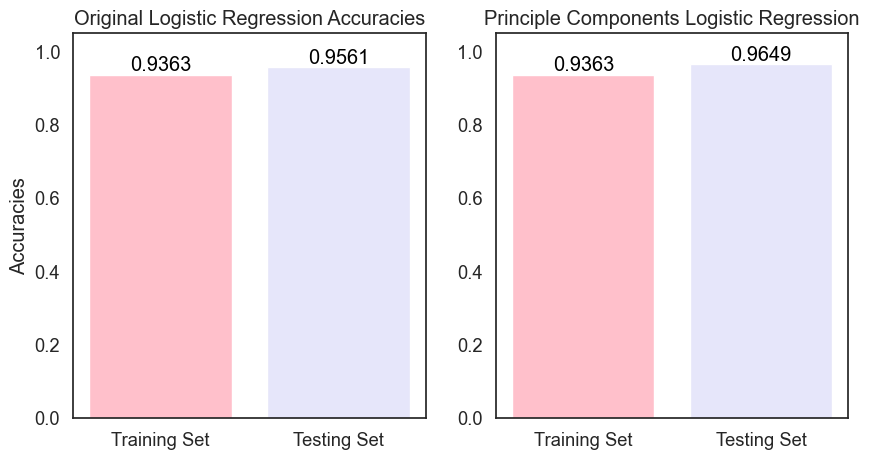

In [132]:
#plot_side_by_side(['Original Decision Tree', 'Principle Components Decision Tree'], [accuracy_train_dt, accuracy_train_dt_PCA], [accuracy_test_dt, accuracy_test_dt_PCA], rotate=45, title1='Original Decision Tree Accuracies', title2='Principle Components Decision Tree', ylabel='Accuracies',ylim=1.05)

plot_side_by_side(['Training Set', 'Testing Set'], [accuracy_train_lr, accuracy_test_lr], [accuracy_train_lr_PCA, accuracy_test_lr_PCA], rotate=0, title1='Original Logistic Regression Accuracies', title2='Principle Components Logistic Regression', ylabel='Accuracies',ylim=1.05)

> We observe a similar accuracy for both the training and testing sets when using only the top 5 PCA components. This indicates that despite reducing the number of features, the model is still able to capture a significant amount of information necessary for accurate predictions. It is likely that noise in the original dataset was filtered out when using PCA, resulting in the similar accuracies, despite using less information.

> By using the top 5 PCA components, we achieve a good balance between feature reduction and preserving the essential characteristics of the data. This reduction in dimensionality can be advantageous in terms of computational efficiency and mitigating the risk of overfitting.



## Part 2 - A Clustering Analysis on Airlines Safety Records

**Defining the functions to be used in this question.**

In [68]:
def plot_silhouette(X):
    # Define a list to store the silhouette scores
    silhouette_scores = []
    # Perform K-means clustering for values of K ranging from 2 to 8
    for k in range(2, 9):
        # Create a K-means instance
        kmeans = KMeans(n_clusters=k, random_state=5508, n_init=10)
        kmeans.fit(X)
        labels = kmeans.predict(X)
        silhouette_avg = silhouette_score(X, labels)
        silhouette_scores.append(silhouette_avg)

    # Plot the silhouette scores
    plt.plot(range(2, 9), silhouette_scores, marker='o')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score for K-means Clustering')
    plt.show()


In [69]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

def plot_silhouette_and_elbow(X_data):
    # Define a list to store the silhouette scores and SSE
    silhouette_scores = []
    sse = []
    
    # Perform K-means clustering for values of K ranging from 2 to 8
    for k in range(2, 9):
        # Create a K-means instance
        kmeans = KMeans(n_clusters=k, random_state=5508, n_init=10)
        kmeans.fit(X_data)
        labels = kmeans.predict(X_data)
        
        # Calculate silhouette score and append to the list
        silhouette_avg = silhouette_score(X_data, labels)
        silhouette_scores.append(silhouette_avg)
        
        # Calculate SSE and append to the list
        sse.append(kmeans.inertia_)
    
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plot silhouette scores on the left subplot
    ax1.plot(range(2, 9), silhouette_scores, marker='o')
    ax1.set_xlabel('Number of Clusters (K)')
    ax1.set_ylabel('Silhouette Score')
    ax1.set_title('Silhouette Score for K-means Clustering')
    
    # Plot SSE on the right subplot
    ax2.plot(range(2, 9), sse, marker='o')
    ax2.set_xlabel('Number of Clusters (K)')
    ax2.set_ylabel('Sum of Squared Distances')
    ax2.set_title('Elbow Analysis for K-means Clustering')
    
    # Adjust spacing between subplots
    plt.tight_layout()
    
    # Show the plot
    plt.show()


In [70]:
def plot_elbow(X):
    # Define a list to store the sum of squared distances (SSE)
    sse = []
    
    # Perform K-means clustering for values of K ranging from 1 to 10
    for k in range(2, 9):
        # Create a K-means instance
        kmeans = KMeans(n_clusters=k, random_state=5508, n_init=10)
        kmeans.fit(X)
        
        # Append the sum of squared distances to the list
        sse.append(kmeans.inertia_)
    
    # Plot the SSE values
    plt.plot(range(2, 9), sse, marker='o')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Sum of Squared Distances')
    plt.title('Elbow Analysis for K-means Clustering')
    plt.show()


In [71]:
def plot_knife(X_data):

    X_data = pd.DataFrame(X_data)

    for n_clusters in range(2,9):
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(X_data) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        clusterer = KMeans(n_clusters=n_clusters, n_init=10, random_state=5508)
        cluster_labels = clusterer.fit_predict(X)

        # Compute the silhouette scores for each sample
        silhouette_avg = silhouette_score(X_data, cluster_labels)
        print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

        sample_silhouette_values = silhouette_samples(X_data, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )

            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            y_lower = y_upper + 10

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(
            X_data.values[:, 0] , X_data.values[:, 1] , marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
        )

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        ax2.scatter(
            centers[:, 0],
            centers[:, 1],
            marker="o",
            c="white",
            alpha=1,
            s=200,
            edgecolor="k",
        )

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

        ax2.set_title("The visualisation of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(
            "Silhouette analysis for KMeans clustering on airline safety data with n_clusters = %d"
            % n_clusters,
            fontsize=14,
            fontweight="bold",
        )

    plt.show()


In [72]:
def plot_knife(X_data):
    X_data = pd.DataFrame(X_data)
    
    fig, axes = plt.subplots(4, 2, figsize=(18, 28))
    plt.subplots_adjust(hspace=0.3, top=0.95)

    for n_clusters, ax1 in zip(range(2, 9), axes.flatten()):
        # The 1st subplot is the silhouette plot
        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(X_data) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        clusterer = KMeans(n_clusters=n_clusters, n_init=10, random_state=5508)
        cluster_labels = clusterer.fit_predict(X_data)

        # Compute the silhouette scores for each sample
        silhouette_avg = silhouette_score(X_data, cluster_labels)
        print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

        sample_silhouette_values = silhouette_samples(X_data, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )

            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            y_lower = y_upper + 10

        ax1.set_title(f"The silhouette plot for n_clusters = {n_clusters}")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])
        ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # Display silhouette score
        ax1.text(0.5, 0.95, f"Silhouette Score: {silhouette_avg:.3f}", transform=ax1.transAxes, ha="center", va="top")

    # Remove the final empty plot
    fig.delaxes(axes[3, 1])

    plt.suptitle("Silhouette analysis for KMeans clustering on airline safety data", fontsize=14, fontweight="bold")
    plt.show()


In [204]:
def display_cluster_lists(Z, data, thresh):
    # Assign cluster labels based on the chosen cutoff
    clusters = fcluster(Z, t=thresh, criterion='distance')

    # Create a dictionary to store the states in each cluster
    cluster_states = {}

    # Iterate over the unique cluster labels
    for cluster_label in set(clusters):
        # Filter the dataset based on the current cluster label
        states = data.loc[clusters == cluster_label, 'State'].tolist()
        
        # Store the list of states in the cluster dictionary
        cluster_states[cluster_label] = states

    # Print the states in each cluster
    for cluster_label, states in cluster_states.items():
        print(f"Cluster {cluster_label}: {states}")


In [74]:
def plot_sns(original_data, vars, labels, title='Pairplot for Features Showing KMeans Clusters'):
    colours = sns.color_palette('Set2', n_colors=3)

    # Set a larger font size
    sns.set(font_scale=1.2, style="white")

    # Create a copy of the data with the cluster labels
    data_with_clusters = original_data.copy()
    data_with_clusters['Cluster'] = labels

    # Plot pairplot
    g = sns.pairplot(data_with_clusters, vars=vars.columns, hue='Cluster', palette=colours)
    
    # Set the title
    g.fig.suptitle(title, y=1.03)

    # Show the plot
    plt.show()


## Part 2 - Task 1

**Silhouette scores and Elbow for K-mean clustering at varying Ks**

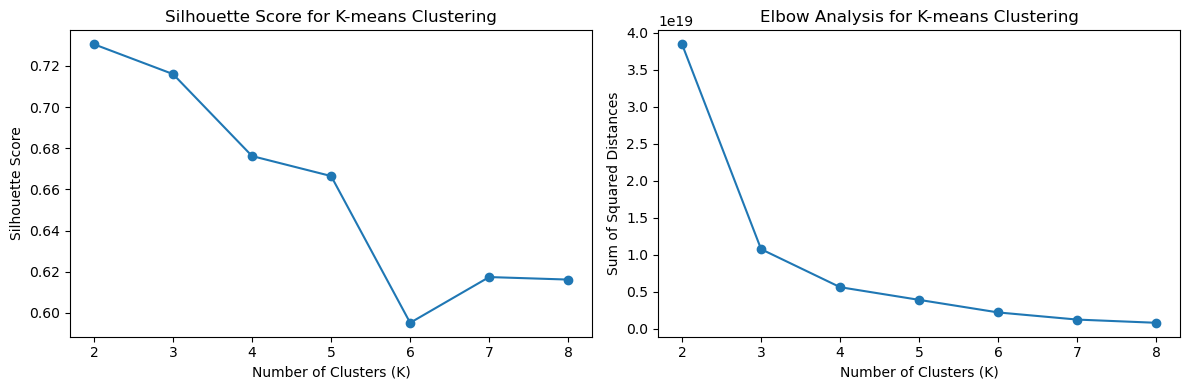

In [75]:
# Load the dataset
airline_data = pd.read_csv('airline-safety.csv')

# Extract the relevant columns for clustering
X = airline_data.iloc[:, 1:]
plot_silhouette_and_elbow(X)

For n_clusters = 2 The average silhouette_score is : 0.7305442197296746
For n_clusters = 3 The average silhouette_score is : 0.7160523201134374
For n_clusters = 4 The average silhouette_score is : 0.6762292637050054
For n_clusters = 5 The average silhouette_score is : 0.6665190250317176
For n_clusters = 6 The average silhouette_score is : 0.5952308912631032
For n_clusters = 7 The average silhouette_score is : 0.6174498021832919
For n_clusters = 8 The average silhouette_score is : 0.6162280033898976


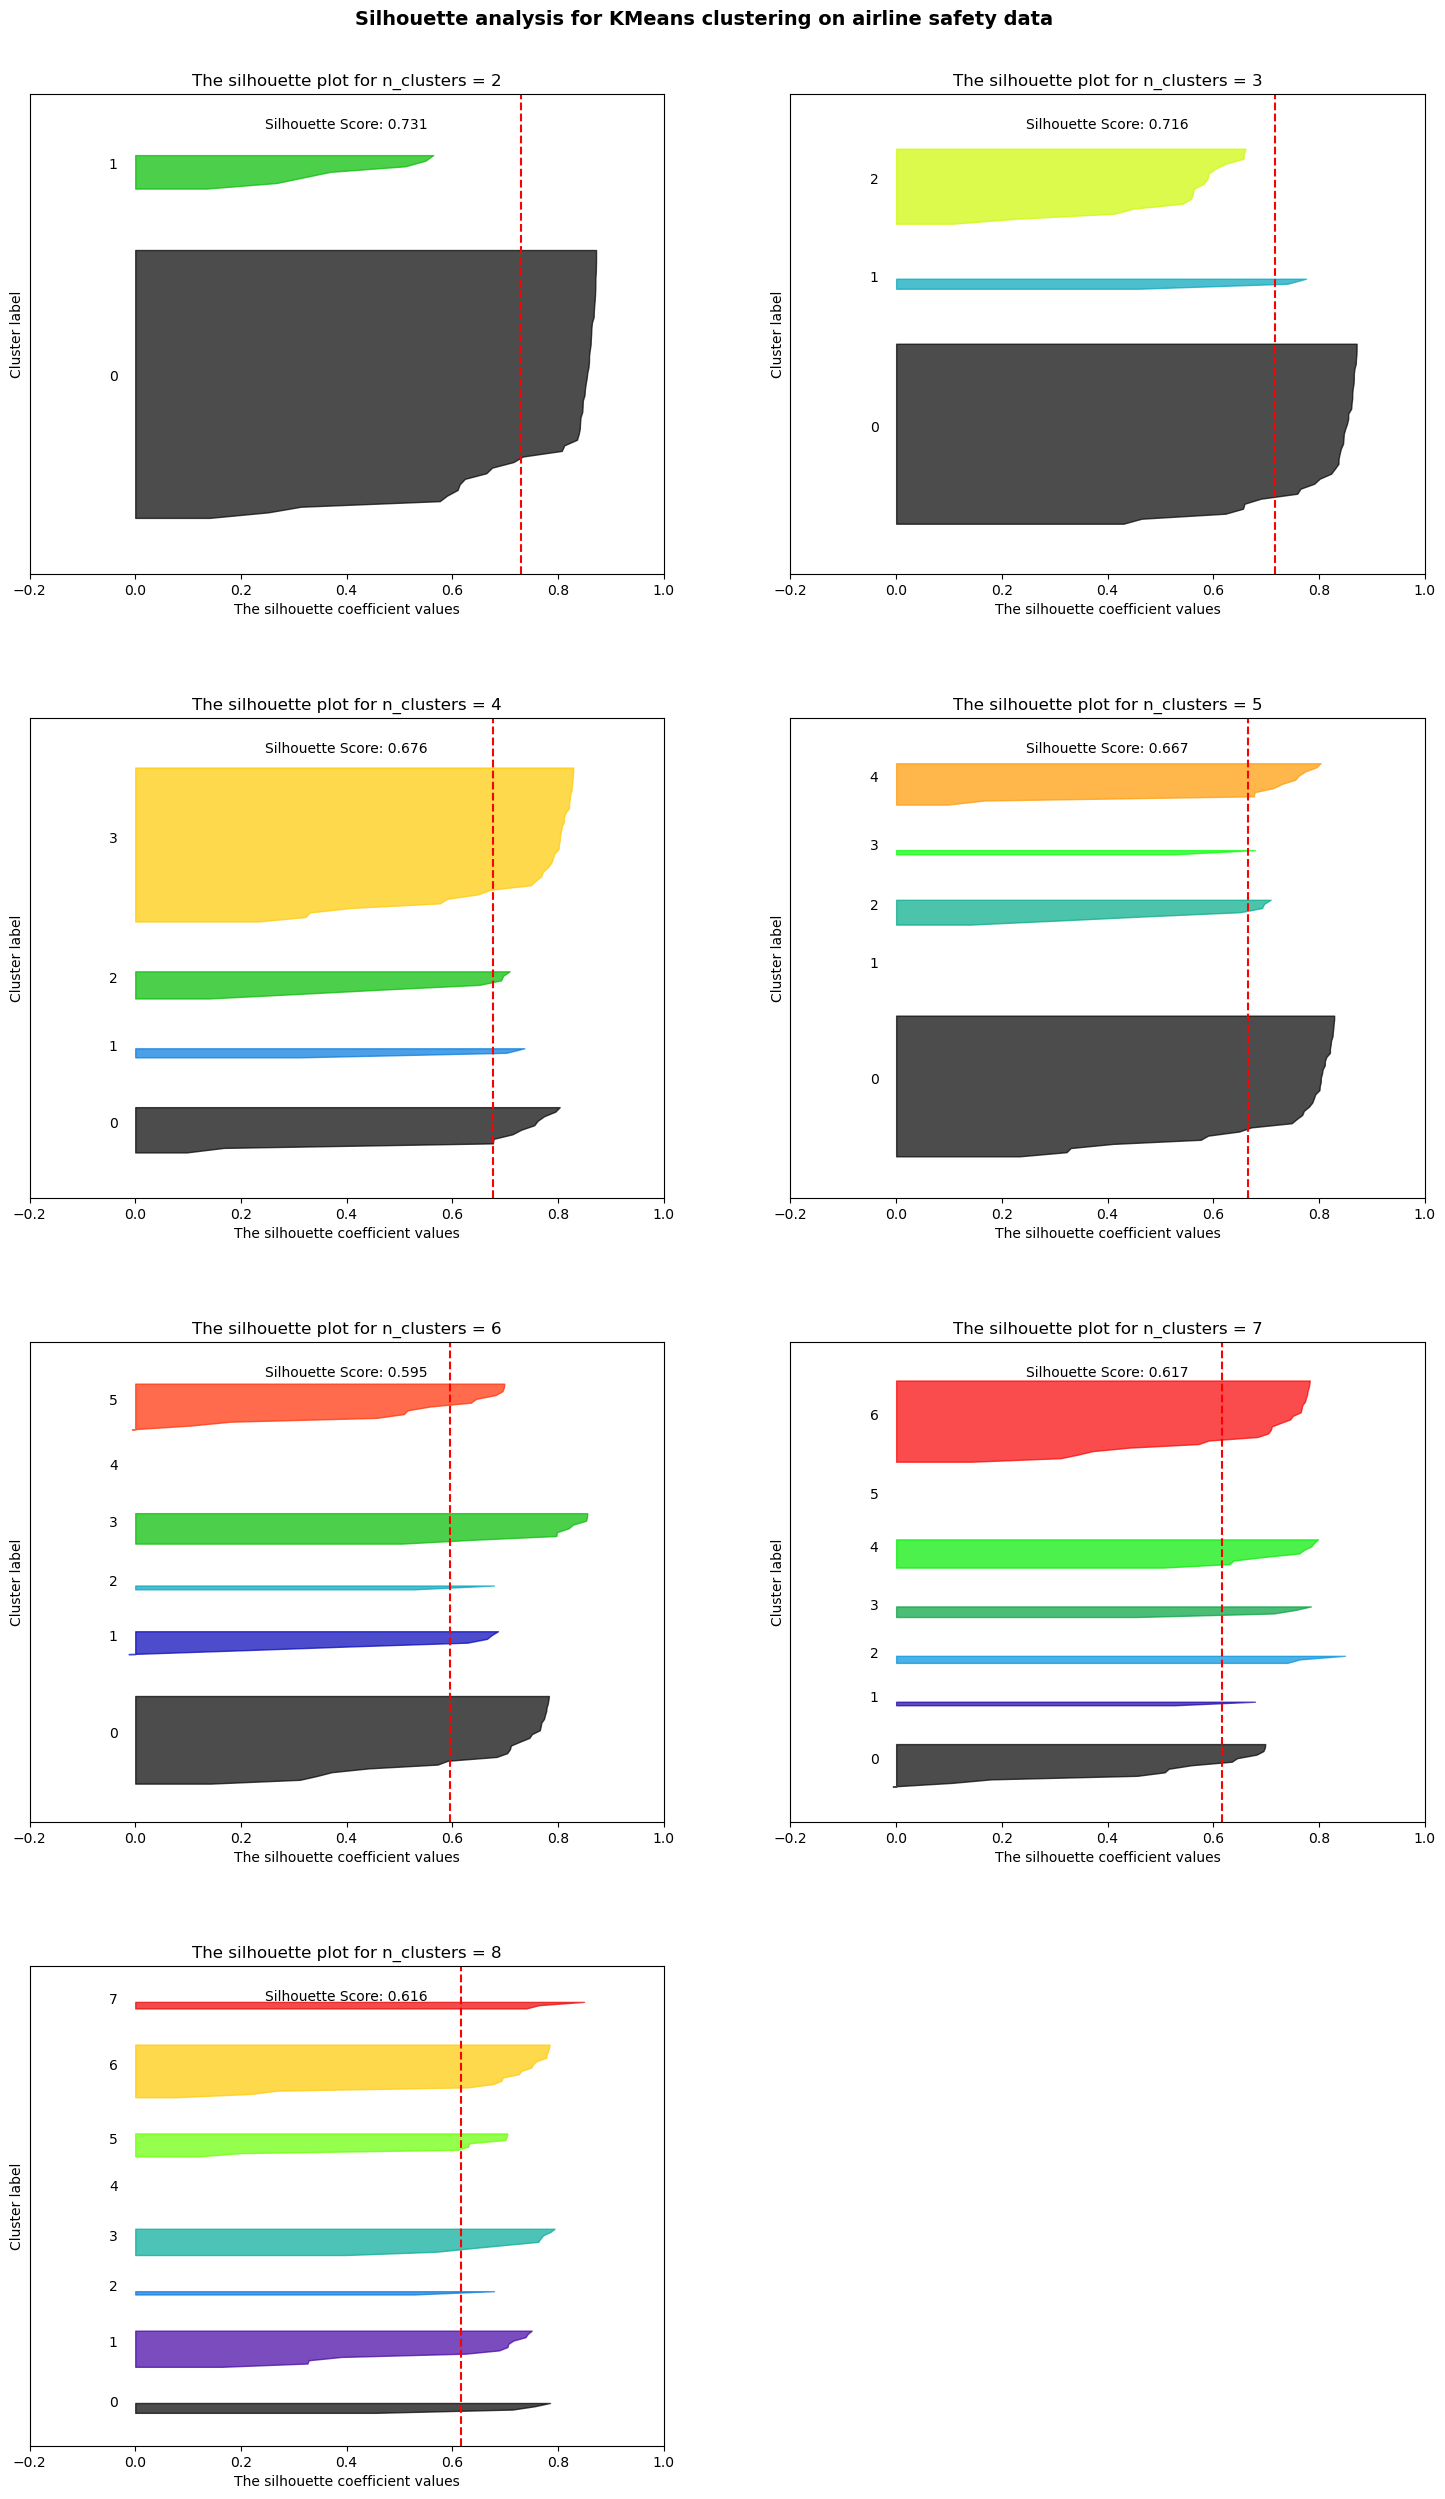

In [76]:
plot_knife(X)

**Silhouette score and Elbow for K-mean clustering at varying Ks for the scaled data**

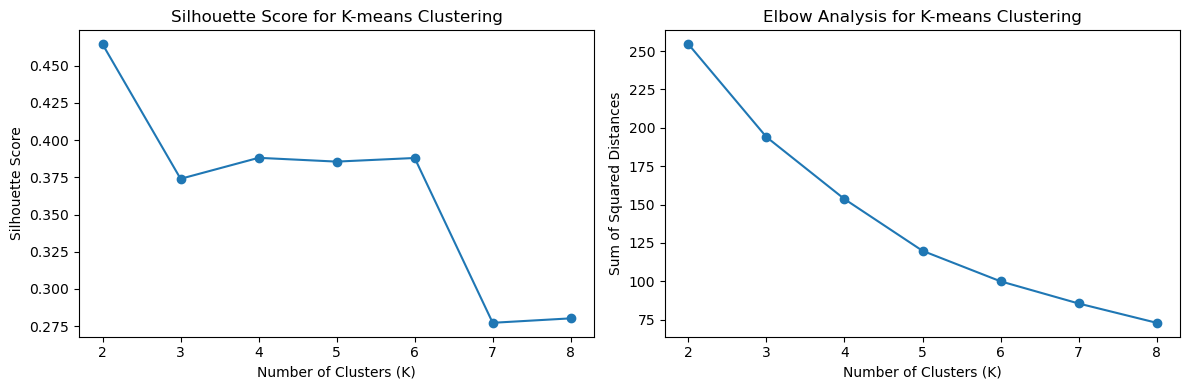

In [77]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
plot_silhouette_and_elbow(X_scaled)

For n_clusters = 2 The average silhouette_score is : 0.4643621133946229
For n_clusters = 3 The average silhouette_score is : 0.37400083752853963
For n_clusters = 4 The average silhouette_score is : 0.38809805715989115
For n_clusters = 5 The average silhouette_score is : 0.38555120339580046
For n_clusters = 6 The average silhouette_score is : 0.38798590669812105
For n_clusters = 7 The average silhouette_score is : 0.27730021961585277
For n_clusters = 8 The average silhouette_score is : 0.28028226160295233


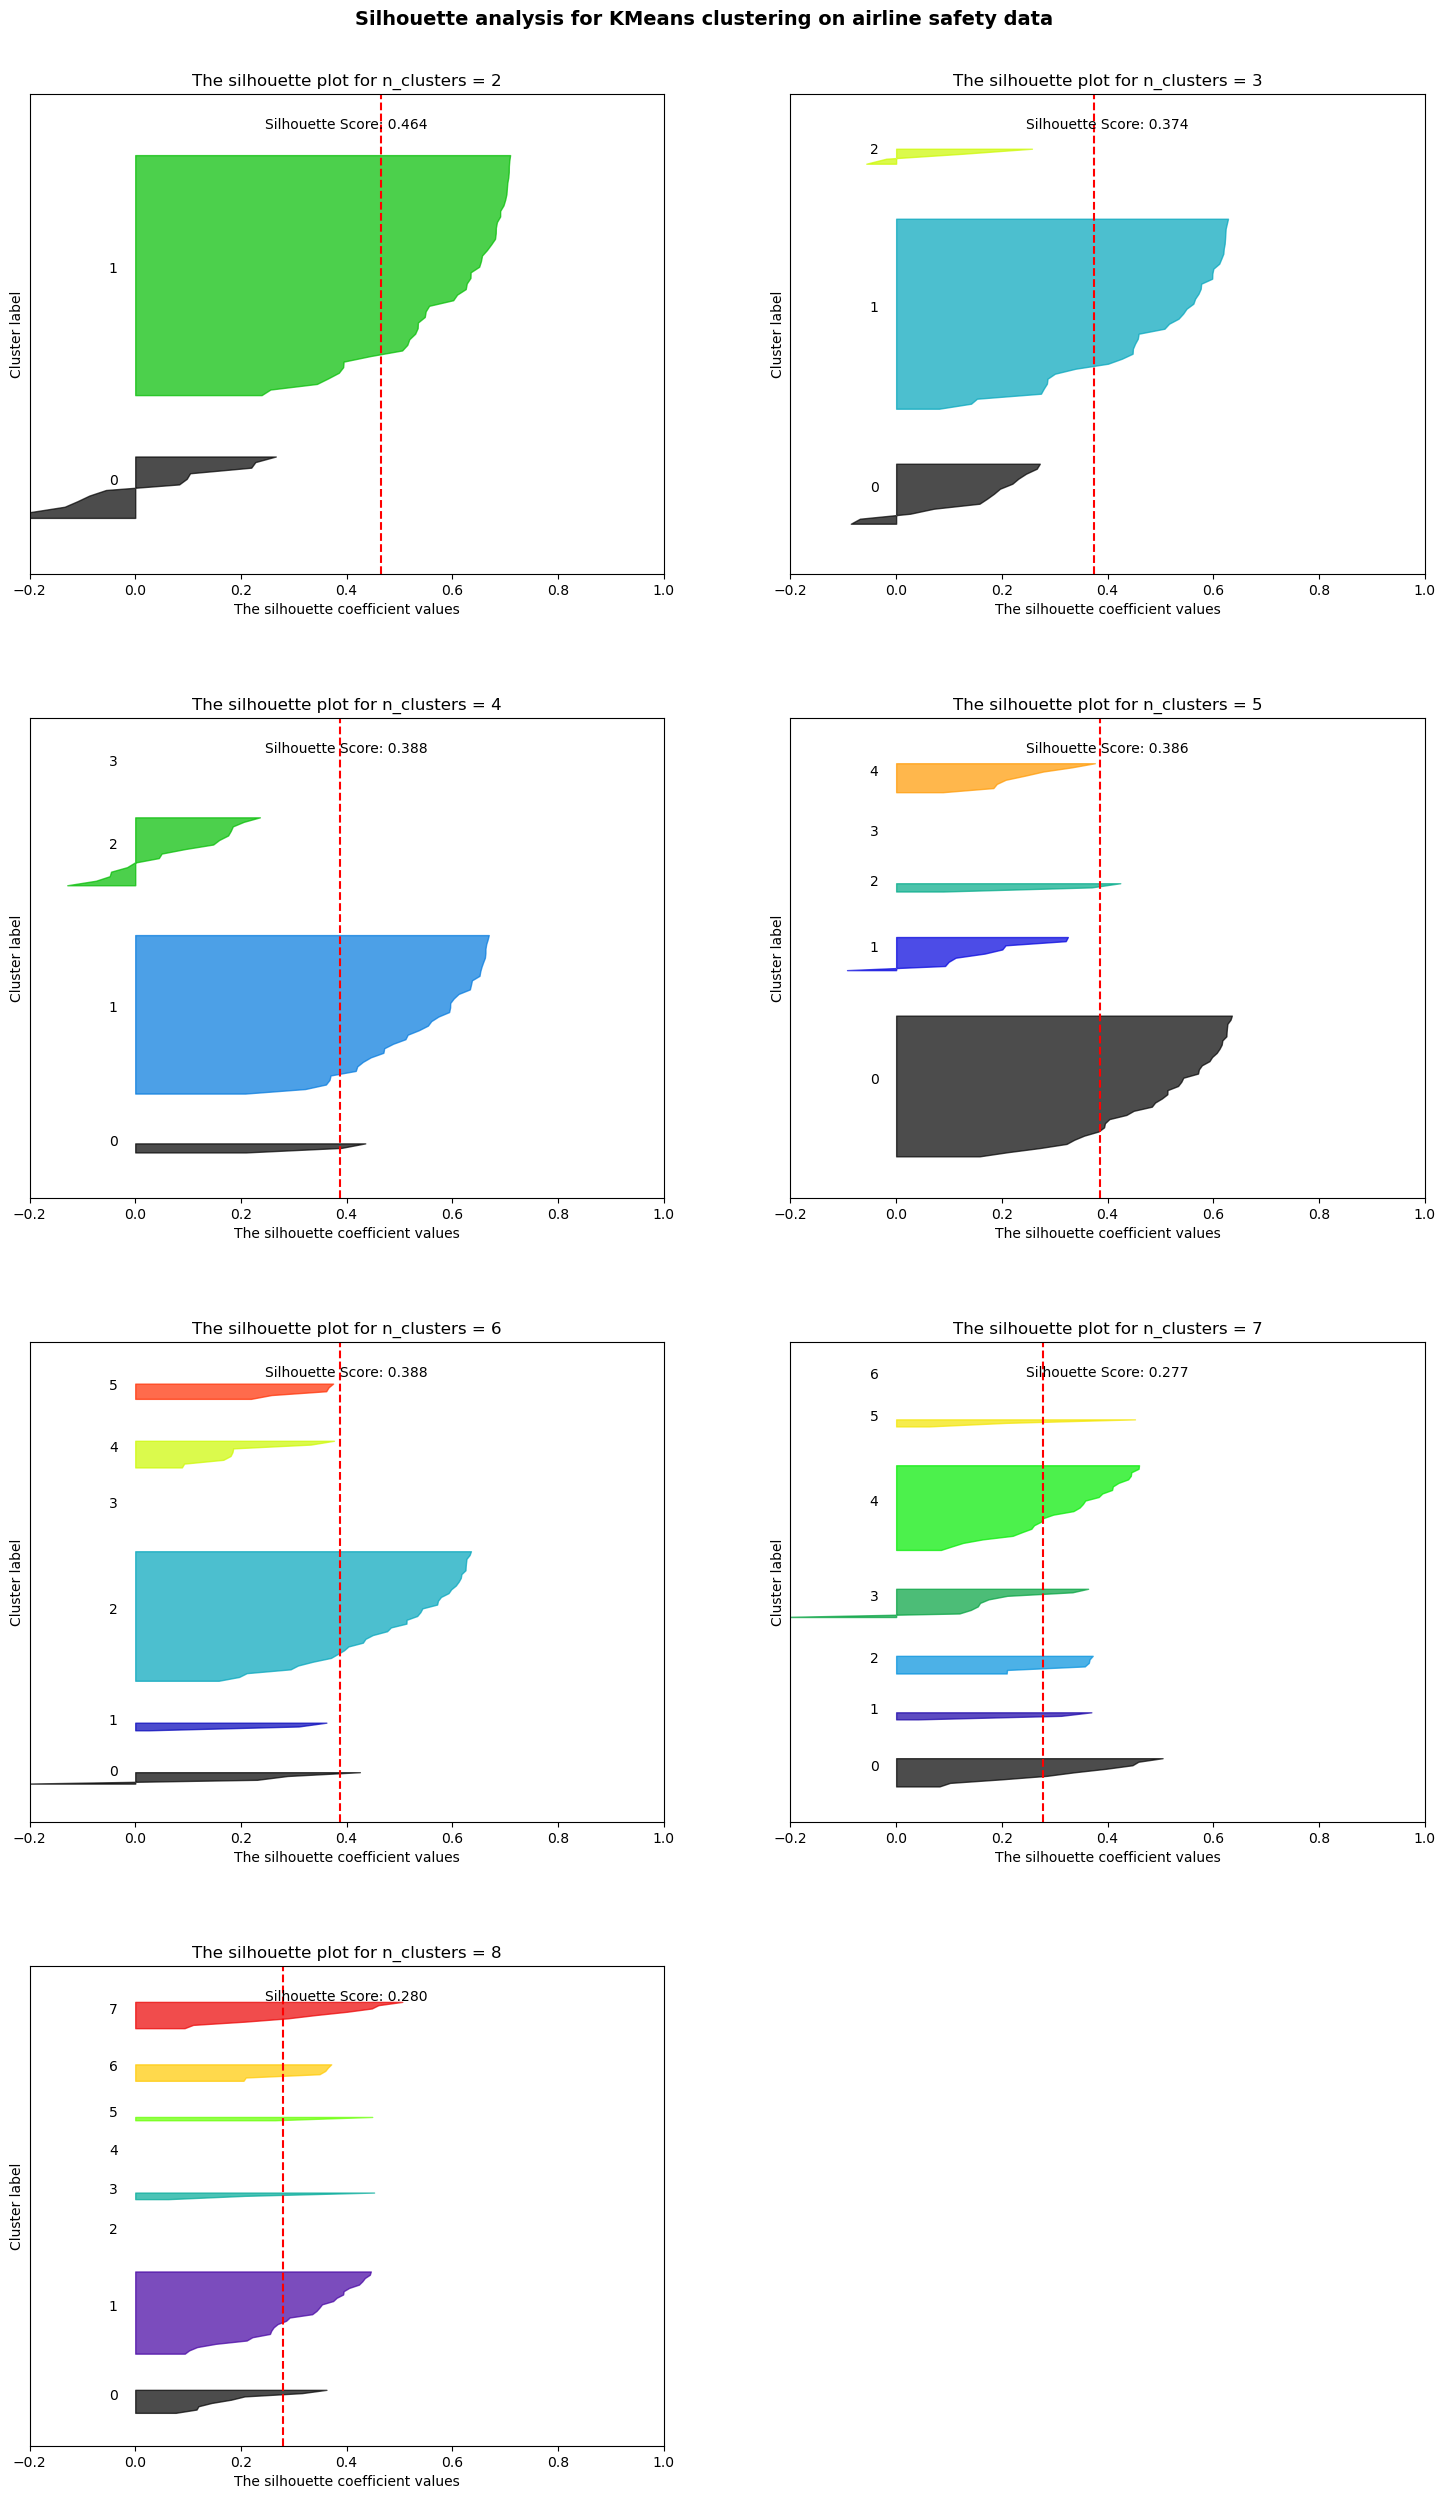

In [78]:
plot_knife(X_scaled)

**Silhouette score and Elbow for K-mean clustering at varying Ks for the uscaled data and dropping the `avail_seat_km_per_week` feature**

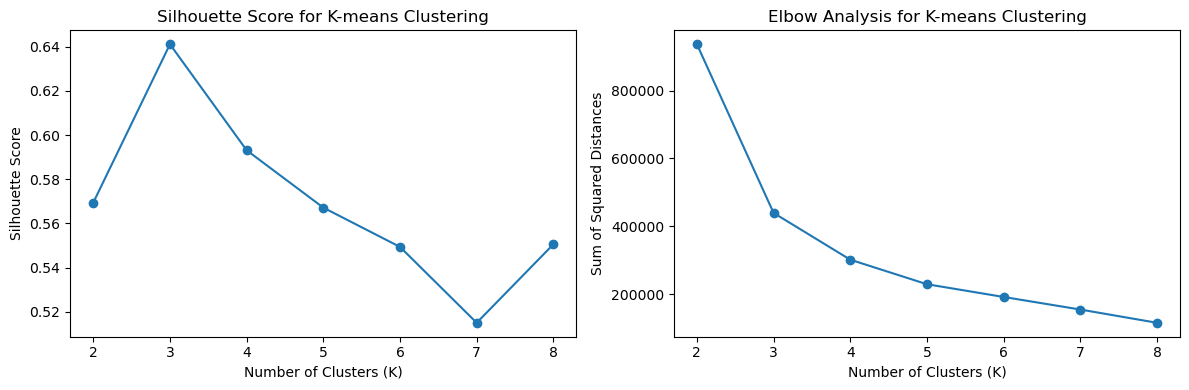

In [79]:
airline_data_dropped = airline_data.drop('avail_seat_km_per_week', axis=1)
# Extract the relevant columns for clustering
X_drop_km = airline_data_dropped.iloc[:, 1:]
plot_silhouette_and_elbow(X_drop_km)

For n_clusters = 2 The average silhouette_score is : 0.5694423760213854
For n_clusters = 3 The average silhouette_score is : 0.6411668038685201
For n_clusters = 4 The average silhouette_score is : 0.5931574130149898
For n_clusters = 5 The average silhouette_score is : 0.5671665160269103
For n_clusters = 6 The average silhouette_score is : 0.5493833413726678
For n_clusters = 7 The average silhouette_score is : 0.5150140902490145
For n_clusters = 8 The average silhouette_score is : 0.5505616672314474


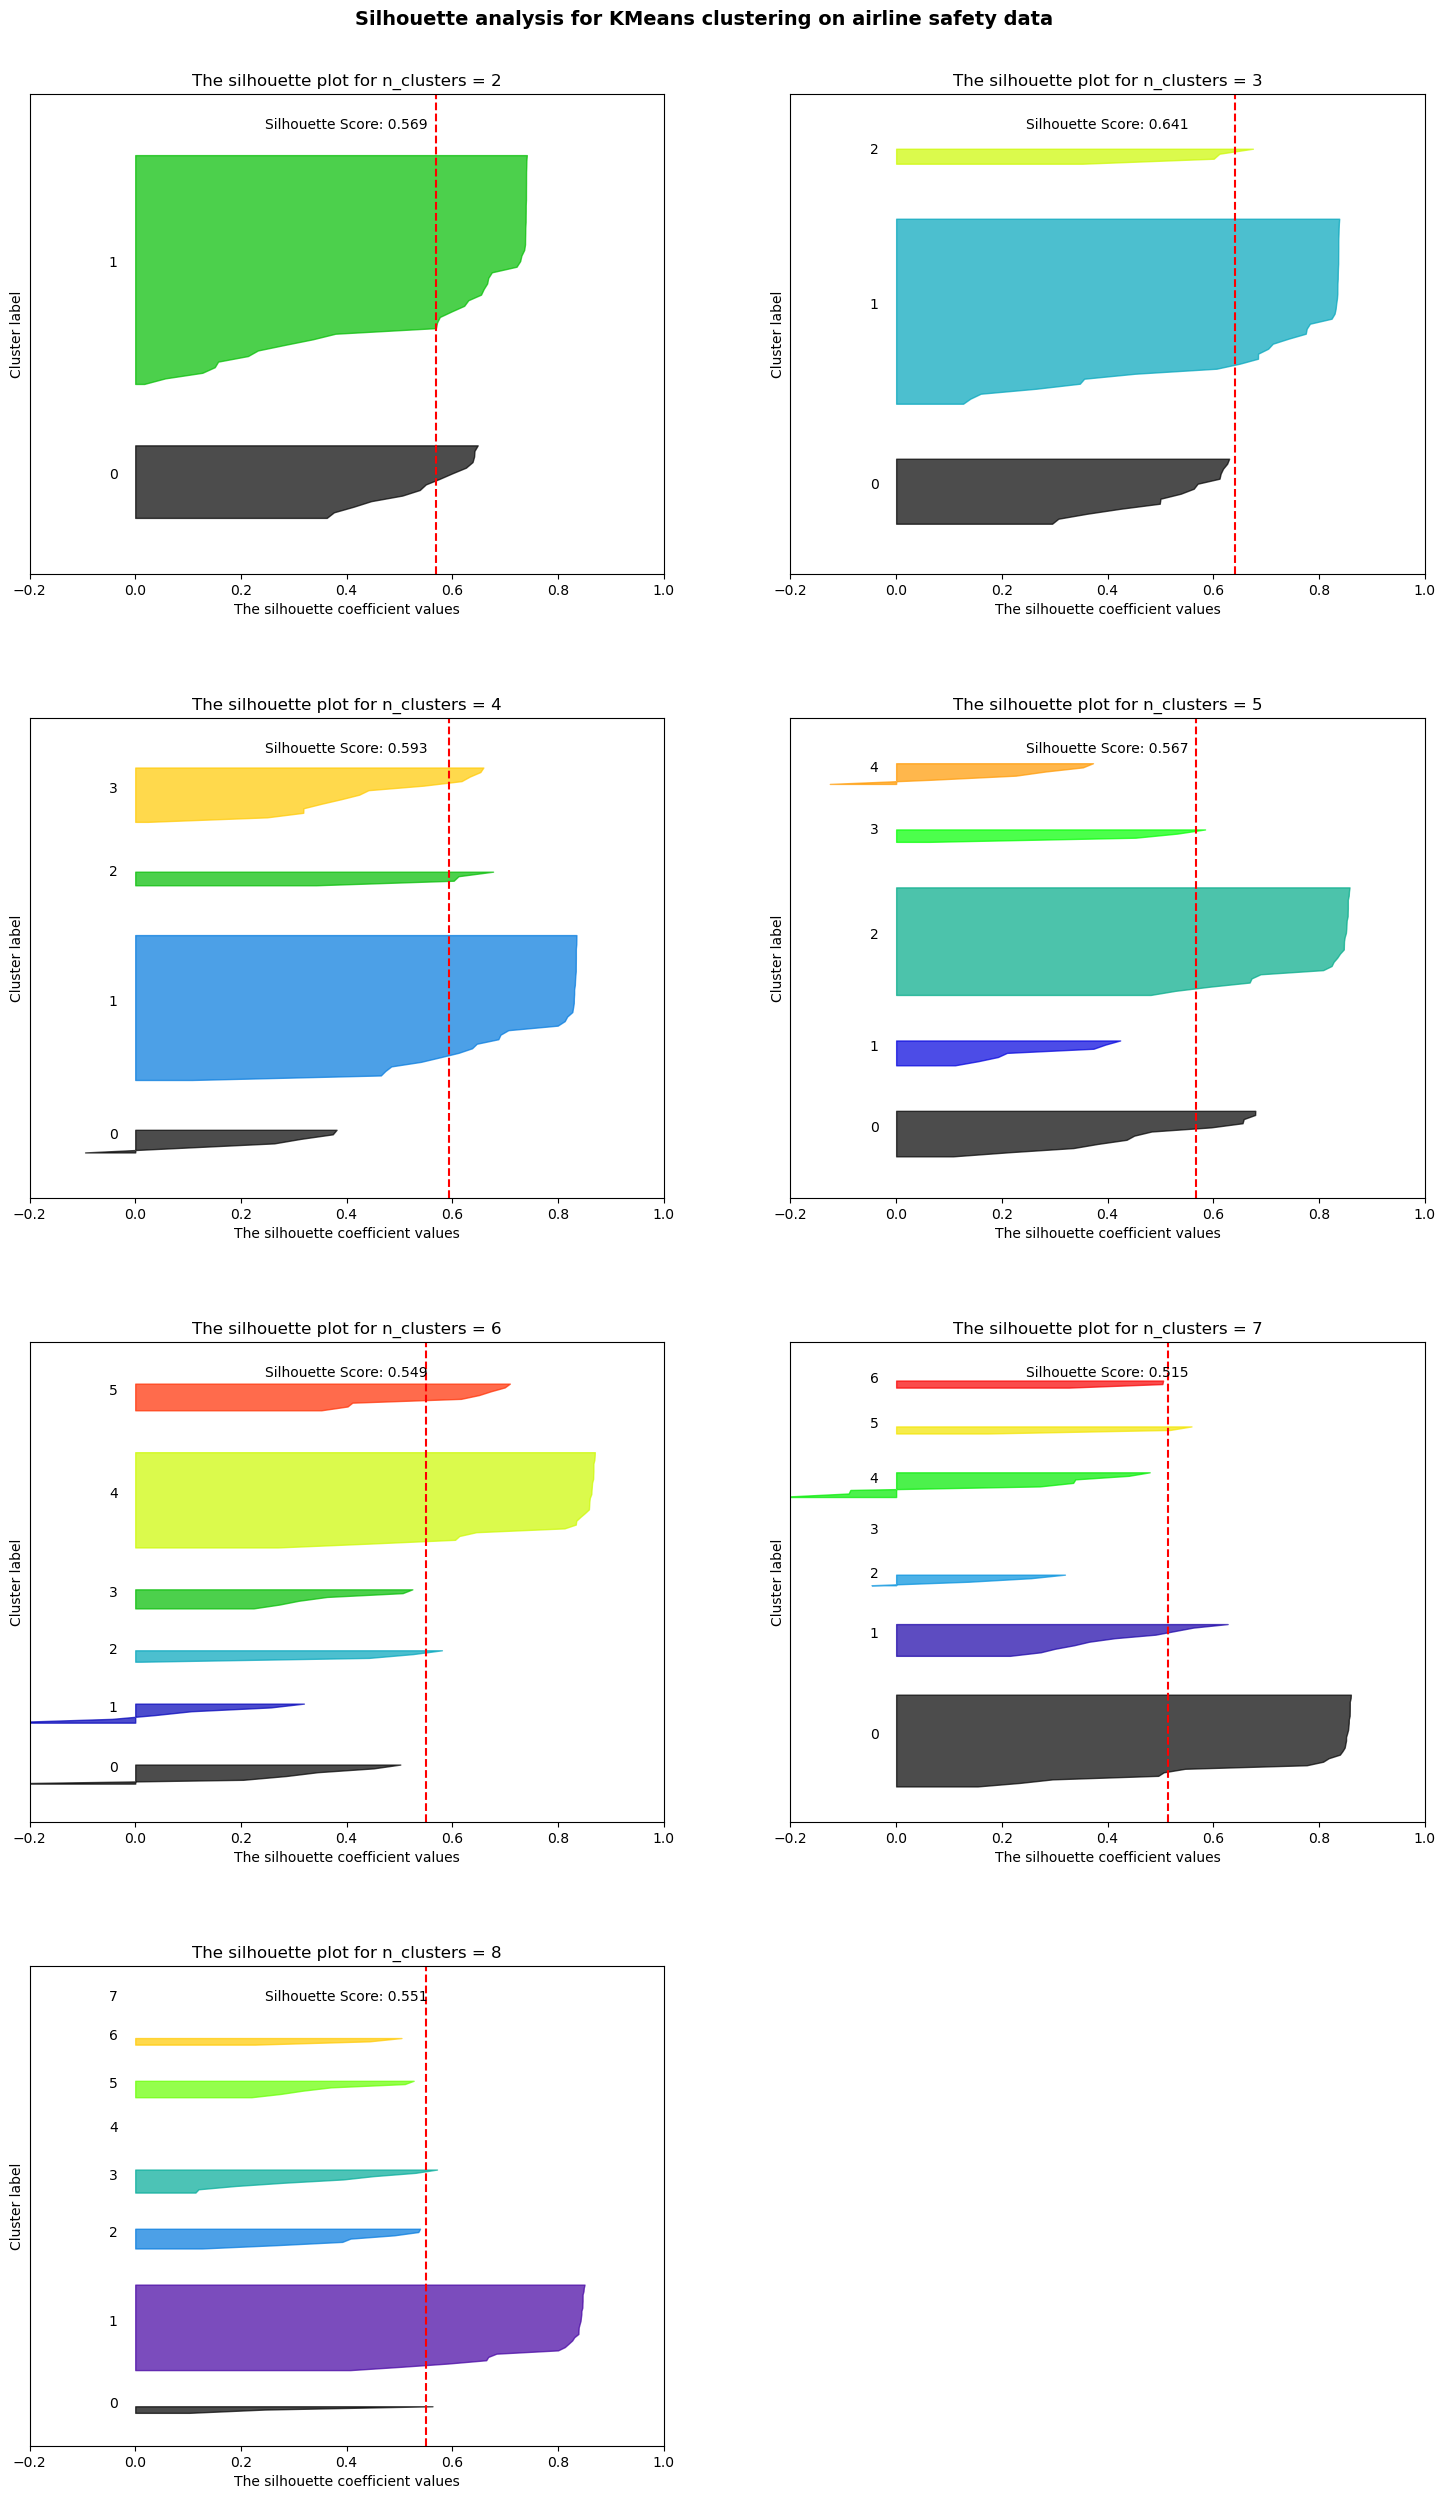

In [80]:
plot_knife(X_drop_km)

FIX 

>  The silhouette score is a measure of how well separated clusters are in a clustering analysis. It quantifies the cohesion and the separation.

> The silhoette score ranges from -1 to 1. A score of 1 indicates that a data point is well within a cluster, a score of 0 inidicates that an instance is between clusters and a score of -1 indicates that an instance may have been assigned to the wrong cluster. The overall silhouette score for a clustering solution is the average silhouette score across all data points. A higher overall silhouette score indicates better-defined and well-separated clusters, while a lower score suggests overlapping or poorly separated clusters.

> In both of the above plots, 2 produces the highest silhouette score. The unscaled data produces higher scores because the scaling process can sometimes distort the relative distances and distributions of the data points. When the data is unscaled, the clustering algorithm may capture the inherent patterns and structures more accurately, resulting in a more well separated clusters. Scaling the data can potentially flatten or compress the data points, causing overlapping or poorly separated clusters, which may lead to lower silhouette scores. Therefore, in this case, the unscaled data preserves the original characteristics of the data and allows the clustering algorithm to perform more effectively, resulting in higher silhouette scores.

> Based just on the silhouette scores, a choice of K=2 seems to be the best. But upon further analysis using silhouette analysis, K=3 proved to be more evenly separated. Hence, I will choose K=3.



- choose 3 of the unscaled but dropped kms coz not same dimension

## Part 2 - Task 2
**Setting K=3**

In [81]:
kmeans = KMeans(n_clusters=3, random_state=5508, n_init=10)
labels = kmeans.fit_predict(X_drop_km)

# Add the cluster labels to the dataset
airline_data['Cluster'] = labels

# Display the results
print(airline_data[['airline', 'Cluster']])


                       airline  Cluster
0                   Aer Lingus        1
1                    Aeroflot*        1
2        Aerolineas Argentinas        1
3                  Aeromexico*        1
4                   Air Canada        1
5                   Air France        2
6                   Air India*        0
7             Air New Zealand*        1
8             Alaska Airlines*        1
9                     Alitalia        1
10          All Nippon Airways        1
11                   American*        2
12           Austrian Airlines        1
13                     Avianca        0
14            British Airways*        1
15             Cathay Pacific*        1
16              China Airlines        0
17                      Condor        1
18                        COPA        1
19          Delta / Northwest*        0
20                    Egyptair        0
21                       El Al        1
22          Ethiopian Airlines        1
23                     Finnair        1


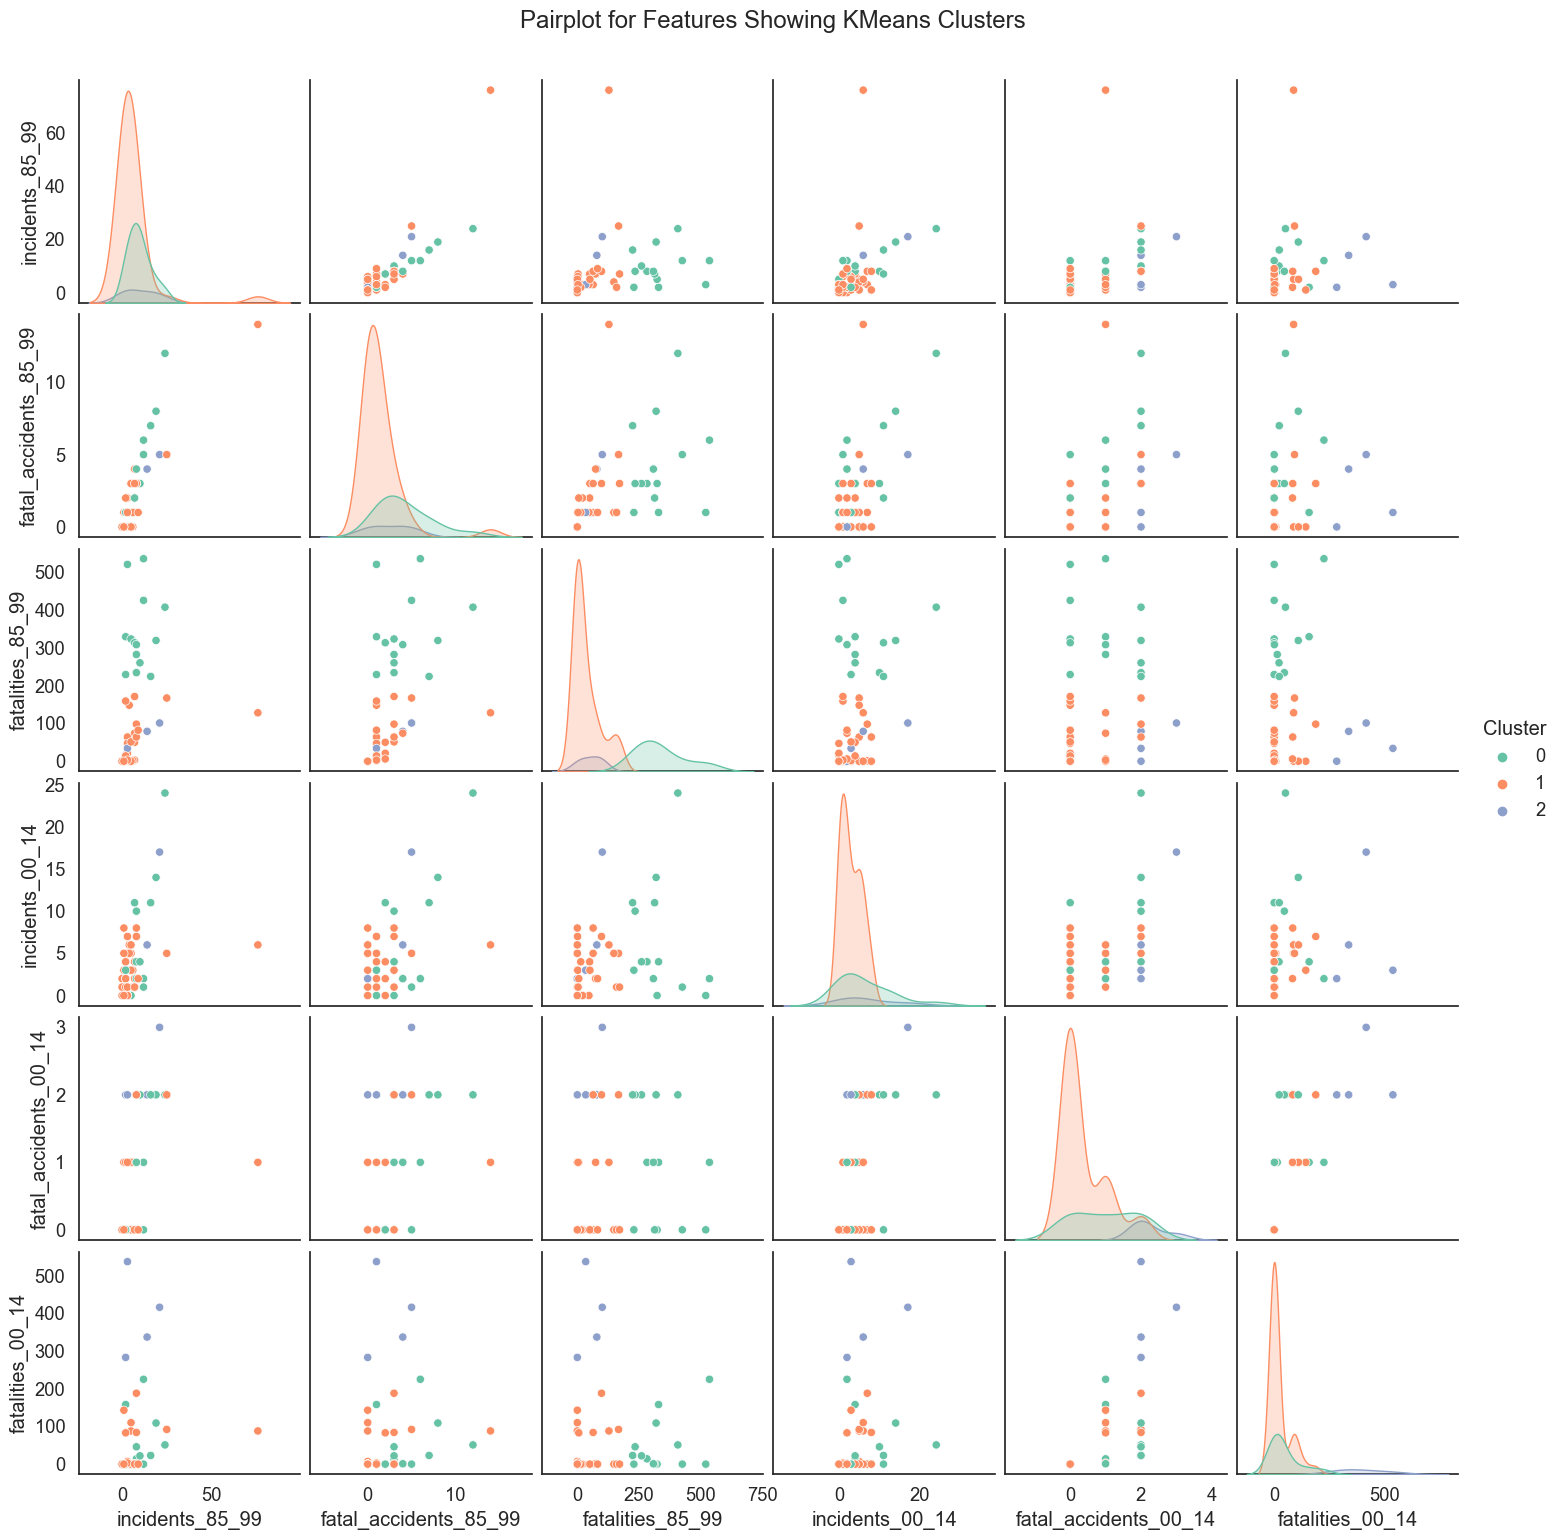

In [82]:
plot_sns(airline_data_dropped, X_drop_km, labels)


> fatalies 89 an d00 show good separation
- when they are overlpapping not so good
- more data will make it easier to interpret

## Part 2 - Task 3

dont htink i should remove any features yet as even though it might improve clustering, the purpose of this model is to determine safety of airlines. If i remove feaures now then i may decrease the overall ability of the model to accuratey categorise based on safety FIX



**Defining functions to be used in this question**

## Part 2 - Task 4

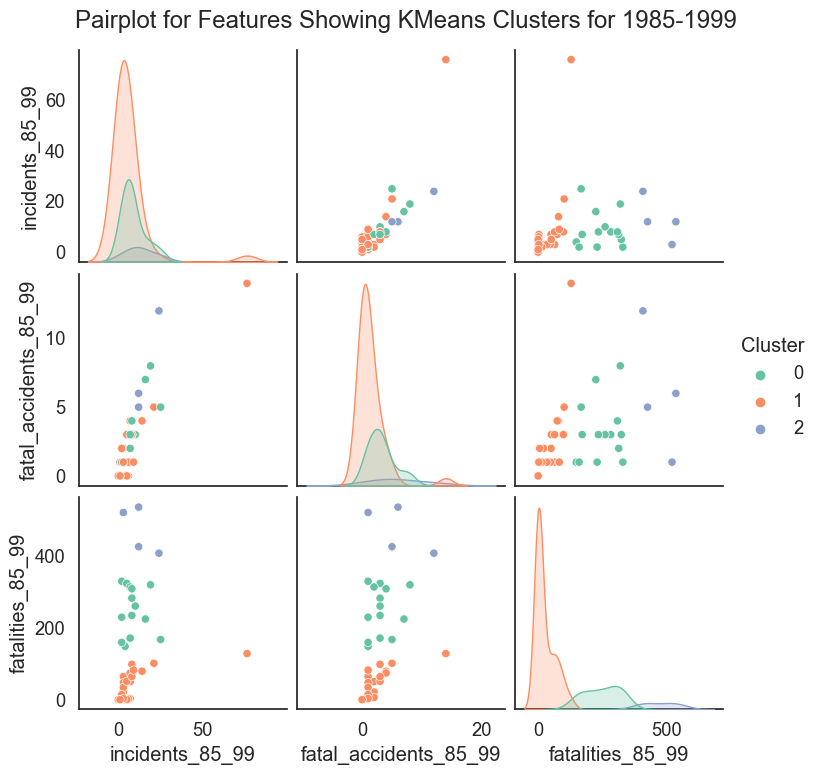

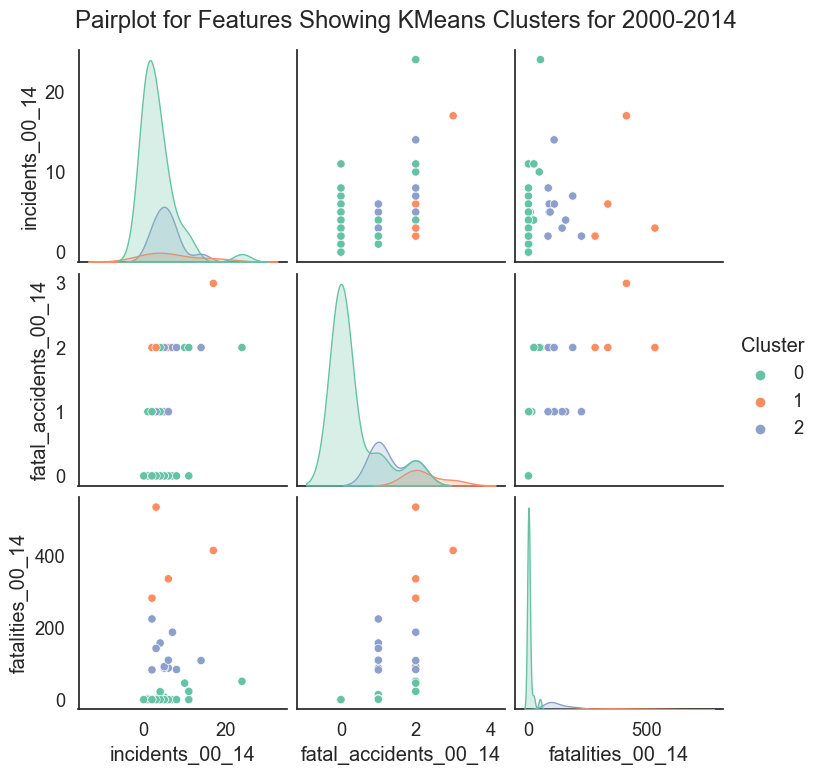

In [83]:
# Extract the relevant columns for clustering (1985-1999)
X_85_99 = airline_data[['incidents_85_99', 'fatal_accidents_85_99', 'fatalities_85_99']]

# Extract the relevant columns for clustering (2000-2014)
X_00_14 = airline_data[['incidents_00_14', 'fatal_accidents_00_14', 'fatalities_00_14']]

# Set random state
random_state = 5508

# Perform K-means clustering (1985-1999)
kmeans_85_99 = KMeans(n_clusters=3, random_state=random_state, n_init=10)
kmeans_85_99.fit(X_85_99)
labels_85_99 = kmeans_85_99.labels_

# Perform K-means clustering (2000-2014)
kmeans_00_14 = KMeans(n_clusters=3, random_state=random_state, n_init=10)
kmeans_00_14.fit(X_00_14)
labels_00_14 = kmeans_00_14.labels_

plot_sns(X_85_99, X_85_99, labels_85_99, title='Pairplot for Features Showing KMeans Clusters for 1985-1999')
plot_sns(X_00_14, X_00_14, labels_00_14, title='Pairplot for Features Showing KMeans Clusters for 2000-2014')

#plot_sns_side_by_side(X_85_99, labels_85_99, 'title1', X_00_14, labels_/00_14, 'title2')


# # Plot the clusters (1985-1999)
# plt.scatter(X_85_99['incidents_85_99'], X_85_99['fatal_accidents_85_99'], c=labels_85_99)
# plt.xlabel('Incidents 85-99')
# plt.ylabel('Fatal Accidents 85-99')
# plt.title('K-means Clustering (1985-1999)')
# plt.show()

# # Plot the clusters (2000-2014)
# plt.scatter(X_00_14['incidents_00_14'], X_00_14['fatal_accidents_00_14'], c=labels_00_14)
# plt.xlabel('Incidents 00-14')
# plt.ylabel('Fatal Accidents 00-14')
# plt.title('K-means Clustering (2000-2014)')
# plt.show()


FIX
need more blue data to make observations

200 to 2014
much fewer incidents
safety prioritised

## Part 2 - Task 5

In [142]:
# Adding a small number to each of the instances to avoid divide-by-0 issues
# Add a number to all entries in the DataFrame

#add_num = 0.00001
add_num = 1

# Create a copy of the DataFrame
airline_data_copy = airline_data.copy()

# Add a small number to the specified columns in the copied DataFrame
airline_data_copy['incidents_00_14'] = airline_data_copy['incidents_00_14'] + add_num
airline_data_copy['incidents_85_99'] = airline_data_copy['incidents_85_99'] + add_num
airline_data_copy['fatal_accidents_00_14'] = airline_data_copy['fatal_accidents_00_14'] + add_num
airline_data_copy['fatal_accidents_85_99'] = airline_data_copy['fatal_accidents_85_99'] + add_num
airline_data_copy['fatalities_00_14'] = airline_data_copy['fatalities_00_14'] + add_num
airline_data_copy['fatalities_85_99'] = airline_data_copy['fatalities_85_99'] + add_num

# Defining new features
incidents_ratio = airline_data_copy['incidents_00_14']/airline_data_copy['incidents_85_99']
fatal_accidents_ratio = airline_data_copy['fatal_accidents_00_14']/airline_data_copy['fatal_accidents_85_99']
fatalities_ratio = airline_data_copy['fatalities_00_14']/airline_data_copy['fatalities_85_99']

# # Replace NaN and infinity with 0
# incidents_ratio = incidents_ratio.replace([np.inf, -np.inf, np.nan], 0)
# fatal_accidents_ratio = fatal_accidents_ratio.replace([np.inf, -np.inf, np.nan], 0)
# fatalities_ratio = fatalities_ratio.replace([np.inf, -np.inf, np.nan], 0)

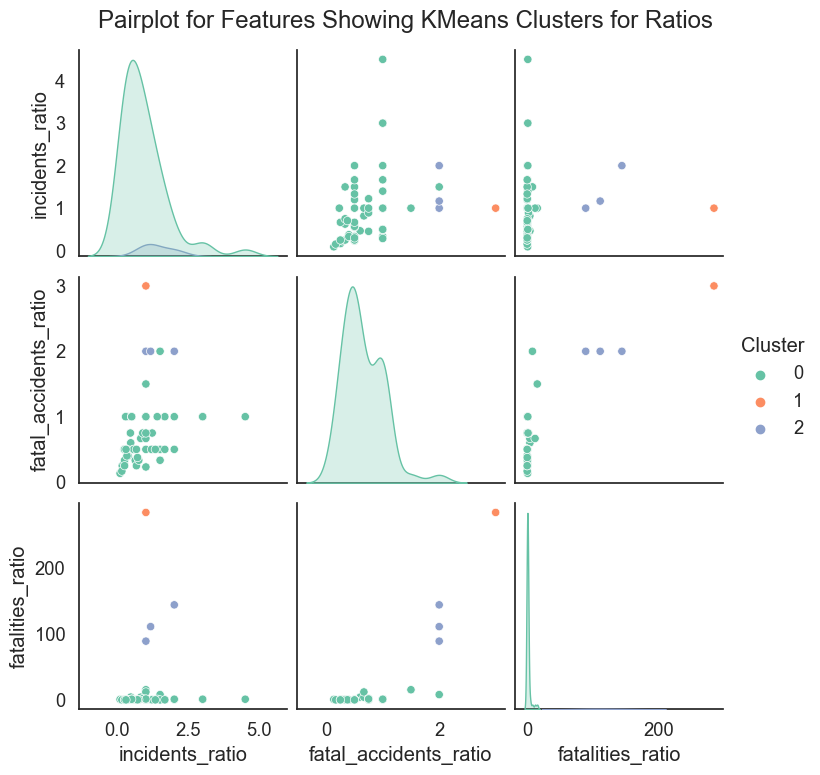

In [147]:
# Combine the new features into a new DataFrame
new_features = pd.DataFrame({'incidents_ratio': incidents_ratio, 'fatal_accidents_ratio': fatal_accidents_ratio, 'fatalities_ratio': fatalities_ratio})

# Set random state
random_state = 5508

# Scale the features
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(new_features)

# Perform K-means clustering with the value of K from Task 1
k = 3  # Value of K from Task 1
kmeans = KMeans(n_clusters=k, random_state=random_state, n_init=10)
kmeans.fit(new_features)
labels = kmeans.labels_

plot_sns(new_features, new_features, labels, title='Pairplot for Features Showing KMeans Clusters for Ratios')



- discuss outliers
- oranbge may be an oulier, anomlyl\might not need a cluster
- maybe oragne is significanlty different, need more research
- differnt comninations of ratios result in different info

In [86]:
# Add the cluster labels to the original dataset
new_features['cluster_labels'] = labels
new_features['airline'] = airline_data['airline']

# Print the cluster analysis results
cluster_analysis = new_features[['airline', 'incidents_ratio', 'fatal_accidents_ratio', 'fatalities_ratio', 'cluster_labels']]
print(cluster_analysis)

                       airline  incidents_ratio  fatal_accidents_ratio  \
0                   Aer Lingus         0.333333               1.000000   
1                    Aeroflot*         0.090909               0.133333   
2        Aerolineas Argentinas         0.285714               1.000000   
3                  Aeromexico*         1.500000               0.500000   
4                   Air Canada         1.000000               1.000000   
5                   Air France         0.466667               0.600000   
6                   Air India*         1.666667               1.000000   
7             Air New Zealand*         1.500000               2.000000   
8             Alaska Airlines*         1.000000               2.000000   
9                     Alitalia         0.625000               0.333333   
10          All Nippon Airways         2.000000               0.500000   
11                   American*         0.818182               0.666667   
12           Austrian Airlines        

only 55 ish instances....


# Part 3 - A clustering analysis on US arrests data

**Defining the functions to be used in this question**

In [186]:
def plot_means(data, set_max_y=True):
    
    # Group the data by cluster and calculate the mean values
    cluster_means = data.groupby('Cluster')['Murder', 'Rape', 'Assault', 'UrbanPop'].mean()

    # Get the maximum mean value across all clusters
    max_mean = cluster_means.max().max()

    # Plotting three bar plots side by side
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    for i, ax in enumerate(axes):
        cluster_data = cluster_means.iloc[i]
        ax.bar(cluster_data.index, cluster_data.values)
        ax.set_title(f'Cluster {i+1}')
        ax.set_ylabel('Mean Value')
        ax.set_xlabel('Variable')

        if set_max_y==True:
            ax.set_ylim([0, max_mean])  # Set a common y-axis range

    plt.tight_layout()
    plt.show()

## Part 3 - Task 1

**Performing hierarchical clustering with complete linkage and Euclidean distance**

In [200]:
data_US = pd.read_csv('USArrests.csv')
X_US = data_US.iloc[:, 1:].values  # Selecting columns 1 to 4 (Murder, Assault, Rape, UrbanPop)

# Calculate the linkage matrix using complete linkage and Euclidean distance
Z = linkage(X_US, method='complete', metric='euclidean')

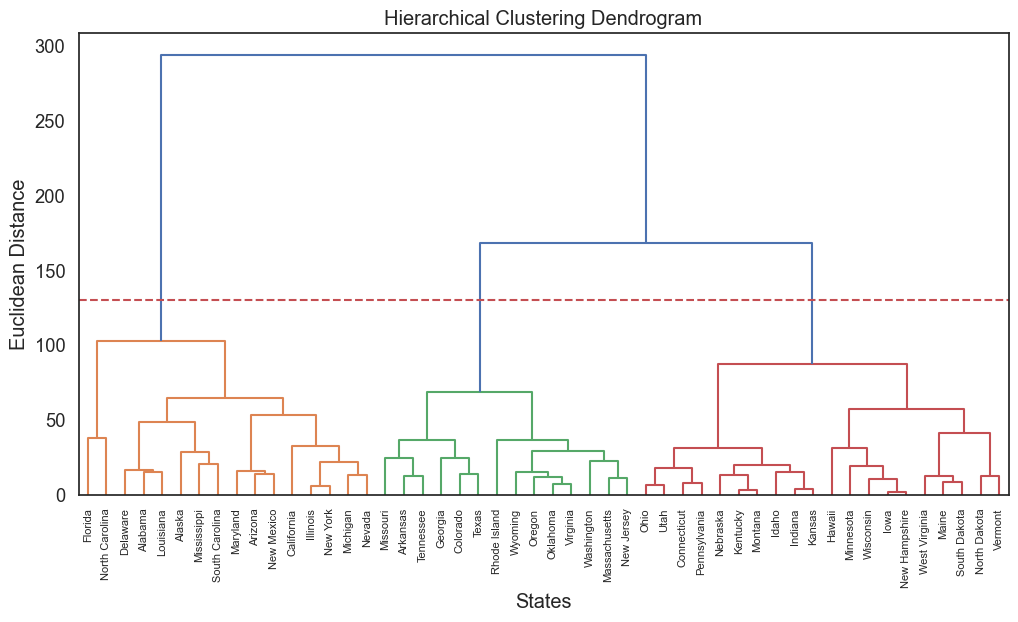

In [201]:
# Plotting the dendrogram

thresh = 130

plt.figure(figsize=(12, 6))
dendrogram(Z, labels=data_US.iloc[:, 0].values, leaf_rotation=90, color_threshold=thresh)
plt.xlabel('States')
plt.ylabel('Euclidean Distance')
plt.title('Hierarchical Clustering Dendrogram')
plt.axhline(y=thresh, color='r', linestyle='--')  # Add the horizontal line at height 130
plt.show()

In [202]:
# Assign cluster labels based on the chosen cutoff
clusters = fcluster(Z, t=thresh, criterion='distance')

# Add the cluster labels to the dataset
data_US['Cluster'] = clusters

# Print the clusters
#print(data_US[['State', 'Cluster']])

**Displaying the states that belong to each cluster**

In [205]:
display_cluster_lists(Z, data_US, thresh=130)

Cluster 1: ['Alabama', 'Alaska', 'Arizona', 'California', 'Delaware', 'Florida', 'Illinois', 'Louisiana', 'Maryland', 'Michigan', 'Mississippi', 'Nevada', 'New Mexico', 'New York', 'North Carolina', 'South Carolina']
Cluster 2: ['Arkansas', 'Colorado', 'Georgia', 'Massachusetts', 'Missouri', 'New Jersey', 'Oklahoma', 'Oregon', 'Rhode Island', 'Tennessee', 'Texas', 'Virginia', 'Washington', 'Wyoming']
Cluster 3: ['Connecticut', 'Hawaii', 'Idaho', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Maine', 'Minnesota', 'Montana', 'Nebraska', 'New Hampshire', 'North Dakota', 'Ohio', 'Pennsylvania', 'South Dakota', 'Utah', 'Vermont', 'West Virginia', 'Wisconsin']


**Plotting the mean variables of each cluster**

/var/folders/7p/23vn8v_n2ld2zplx_01w7kf80000gn/T/ipykernel_36689/37951004.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  cluster_means = data.groupby('Cluster')['Murder', 'Rape', 'Assault', 'UrbanPop'].mean()


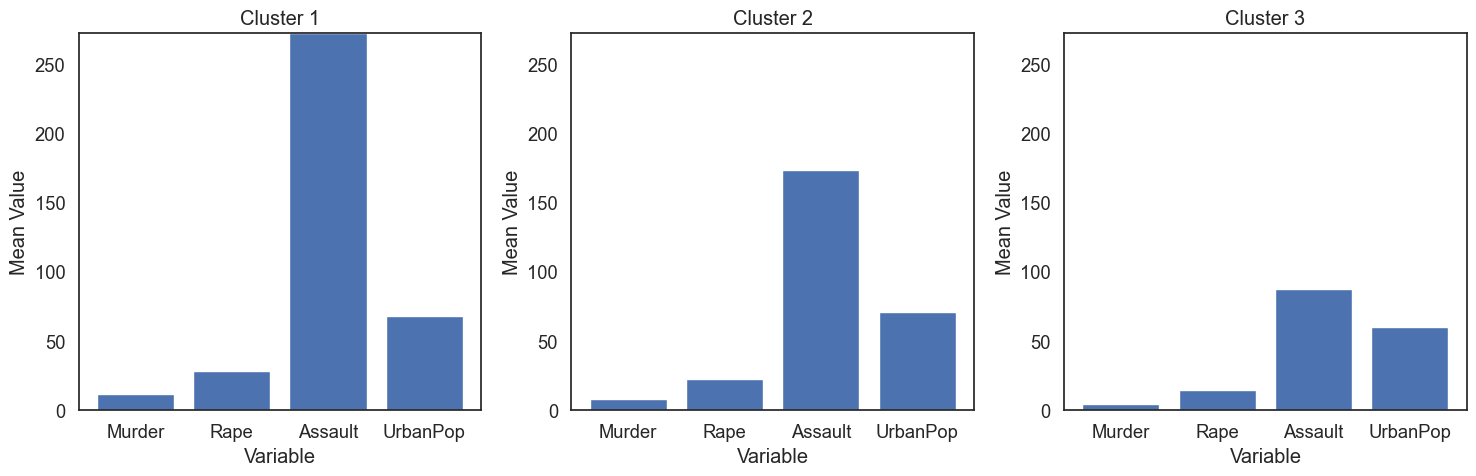

In [167]:
plot_means(data_US)

> The states belonging to each cluster are displayed in the dendrogram and the above list. In the dendrogram, we observe that clusters merge at a similar height, indicating a comparable level of dissimilarity between the merged clusters. The height of each vertical line represents the distance between the merged clusters, with longer lines indicating greater dissimilarity.

> In this dendrogram, the vertical lines within the clusters remain relatively short, suggesting higher similarity within each cluster. In contrast, the lines are longer at the cutoff point, indicating greater dissimilarity between the three clusters.


> Additionally, examining the mean values of the crimes for each cluster reveals a distinct pattern. Cluster 1 exhibits the highest average rates for each crime, followed by cluster 2 and then cluster 3. This pattern suggests that the centroids of these clusters are likely influenced by these mean values, with cluster 1 representing states with relatively higher crime rates and cluster 3 representing states with relatively lower crime rates

> The mean urban population amongst the 3 clusters remains relatively the same. This indicates a consistent distribution of urban population across the states within each cluster. This suggests that the clustering algorithm primarily considered other variables (such as Murder, Rape, and Assault rates) rather than the urban population percentage when forming the clusters.

> With additional data, it would be possible to explore and compare various features that could further quantify the clustering of states. Some potential features to consider could include the cost of living, wages, age distribution, population density, and other relevant socio-economic factors. This would enable a deeper exploration of the relationships between crime rates, urban population, and these additional socio-economic features.

## Part 3 - Task 2

**Reapting task 1 after scaling the data**

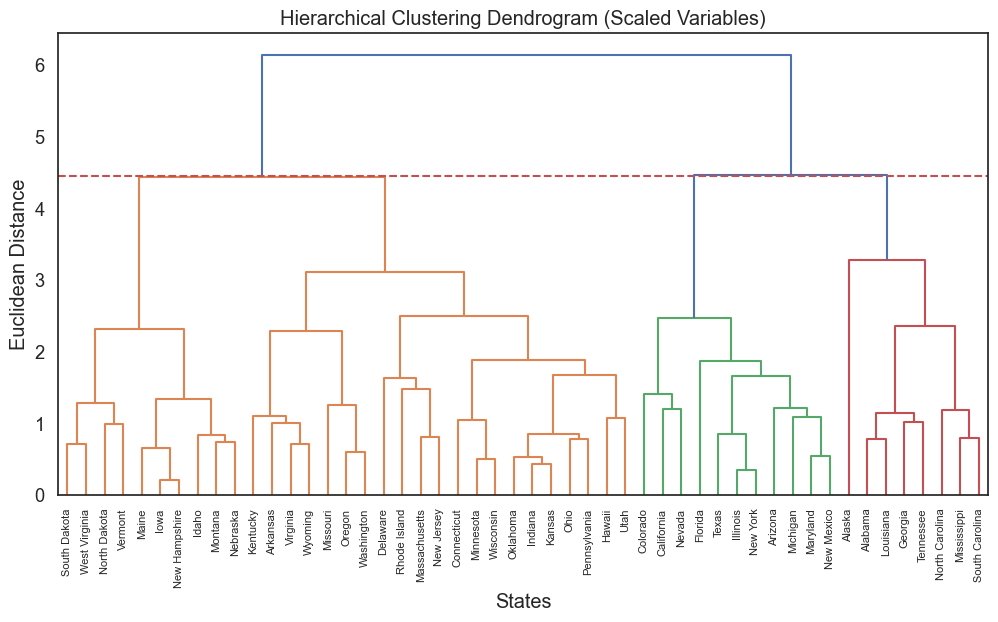

In [219]:
# Scale the variables to have zero mean and unit standard deviation
scaler = StandardScaler()
X_US_scaled = scaler.fit_transform(X_US)

# Calculate the linkage matrix using complete linkage and Euclidean distance
Z_scaled = linkage(X_US_scaled, method='complete', metric='euclidean')

plt.figure(figsize=(12, 6))
dendrogram(Z_scaled, labels=data_US.iloc[:, 0].values, leaf_rotation=90, color_threshold=4.45)
plt.xlabel('States')
plt.ylabel('Euclidean Distance')
plt.title('Hierarchical Clustering Dendrogram (Scaled Variables)')
plt.axhline(y=4.45, color='r', linestyle='--')  # Add the horizontal line at height 130
plt.show()

**Displaying the states that belong to each cluster**

In [222]:
X_US_scaled_pd = pd.DataFrame(X_US_scaled, columns=['Murder', 'Assault', 'UrbanPop', 'Rape'])

# Assign cluster labels based on the chosen cutoff
clusters_scaled = fcluster(Z_scaled, t=4.45, criterion='distance')

# Add the cluster labels to the dataset
X_US_scaled_pd['Cluster'] = clusters_scaled
X_US_scaled_pd['State']=data_US['State']

display_cluster_lists(Z_scaled, X_US_scaled_pd, thresh=4.45)


Cluster 1: ['Arkansas', 'Connecticut', 'Delaware', 'Hawaii', 'Idaho', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Maine', 'Massachusetts', 'Minnesota', 'Missouri', 'Montana', 'Nebraska', 'New Hampshire', 'New Jersey', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Dakota', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']
Cluster 2: ['Arizona', 'California', 'Colorado', 'Florida', 'Illinois', 'Maryland', 'Michigan', 'Nevada', 'New Mexico', 'New York', 'Texas']
Cluster 3: ['Alabama', 'Alaska', 'Georgia', 'Louisiana', 'Mississippi', 'North Carolina', 'South Carolina', 'Tennessee']


**Plotting the mean variables of each cluster**

/var/folders/7p/23vn8v_n2ld2zplx_01w7kf80000gn/T/ipykernel_36689/3558517045.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  cluster_means = data.groupby('Cluster')['Murder', 'Rape', 'Assault', 'UrbanPop'].mean()


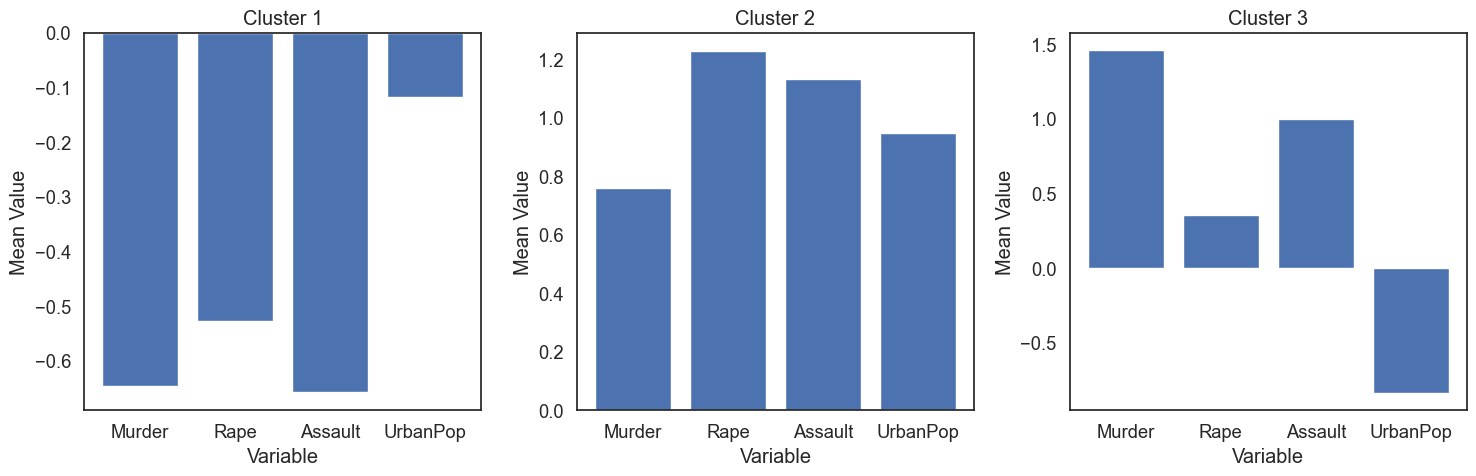

In [215]:
plot_means(X_US_scaled_pd, set_max_y=False)

> Scaling the variables has the effect of standardising the data, ensuring that each variable has the same scale and removing any biases introduced by differences in the original ranges. For this data, `Murder`, `Assault` and `Rape` were measures per 100,000. Whereas the `UrbanPop` was a percentage. It is therefore necessary to scale the data to allow for better data implementation.

> Looking at the dendrogram, we can see that the vertical lines are longer. This indicates a larger dissimilarity between clusters at different levels. This can be attributed to the scaling process, which equalises the importance of each variable in the clustering analysis. As a result, variables with larger magnitudes, such as `Assault` or `Murder`, may contribute more to the dissimilarity between clusters compared to variables with smaller magnitudes, such as `UrbanPop`.

> It is also seen that one cluster contains more states than the other two. Looking at the means of the variables, we see that this cluster has notably lower crime rates than the other clusters. It seems that many states fall into this 'low crime rate' category. although, this is a comparison to other state. It is equally likely that there is a smaller subset of states which has far higher crime rates.




## Part 3 - Task 3

In [216]:
# Perform PCA
pca = PCA(n_components=2)
PC_scores = pca.fit_transform(X_US)

# Calculate the linkage matrix using complete linkage and Euclidean distance on the first two principal components
Z = linkage(PC_scores, method='complete', metric='euclidean')



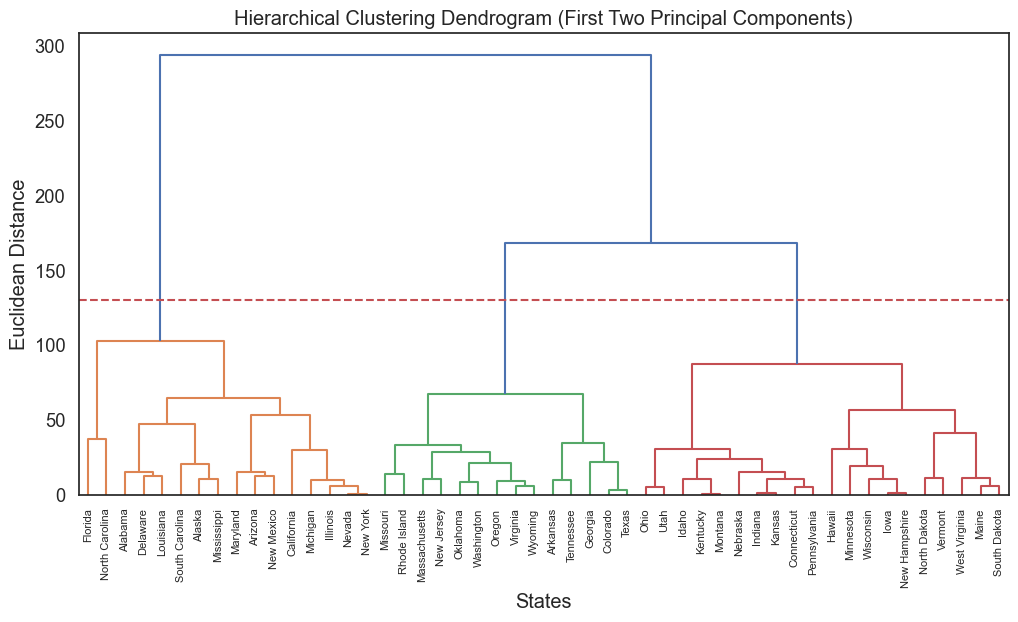

In [217]:
# Cut the dendrogram at a height that results in three distinct clusters
plt.figure(figsize=(12, 6))
dendrogram(Z, labels=data_US.iloc[:, 0].values, leaf_rotation=90, color_threshold=thresh)
plt.xlabel('States')
plt.ylabel('Euclidean Distance')
plt.title('Hierarchical Clustering Dendrogram (First Two Principal Components)')
plt.axhline(y=130, color='r', linestyle='--')  # Add the horizontal line at height 130
plt.show()

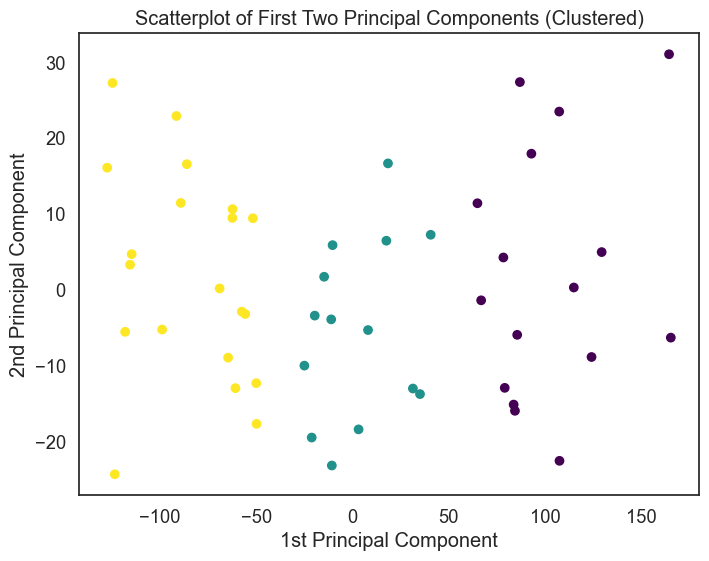

In [95]:
# Assign cluster labels based on the chosen cutoff
clusters = fcluster(Z, t=130, criterion='distance')

# Add the cluster labels to the dataset
data_US['Cluster'] = clusters

# Plot the scatterplot of the first two principal components with different colors for each cluster
plt.figure(figsize=(8, 6))
plt.scatter(PC_scores[:, 0], PC_scores[:, 1], c=clusters, cmap='viridis')
plt.xlabel('1st Principal Component')
plt.ylabel('2nd Principal Component')
plt.title('Scatterplot of First Two Principal Components (Clustered)')
plt.show()

In [96]:
# Add the hierarchical cluster labels to the dataset
data_US['Cluster_Hierarchical'] = clusters

# Group characteristics comparison between hierarchical clustering and original clusters
group_characteristics_hierarchical = data_US.groupby('Cluster_Hierarchical').mean()
group_characteristics_original = data_US.groupby('Cluster').mean()

print('Group Characteristics - Hierarchical Clustering:')
print(group_characteristics_hierarchical)
print('\nGroup Characteristics - Original Clusters:')
print(group_characteristics_original)

Group Characteristics - Hierarchical Clustering:
                         Murder     Assault   UrbanPop       Rape  Cluster
Cluster_Hierarchical                                                      
1                     11.812500  272.562500  68.312500  28.375000      1.0
2                      8.214286  173.285714  70.642857  22.842857      2.0
3                      4.270000   87.550000  59.750000  14.390000      3.0

Group Characteristics - Original Clusters:
            Murder     Assault   UrbanPop       Rape  Cluster_Hierarchical
Cluster                                                                   
1        11.812500  272.562500  68.312500  28.375000                   1.0
2         8.214286  173.285714  70.642857  22.842857                   2.0
3         4.270000   87.550000  59.750000  14.390000                   3.0


/var/folders/7p/23vn8v_n2ld2zplx_01w7kf80000gn/T/ipykernel_36689/2703710257.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  group_characteristics_hierarchical = data_US.groupby('Cluster_Hierarchical').mean()
/var/folders/7p/23vn8v_n2ld2zplx_01w7kf80000gn/T/ipykernel_36689/2703710257.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  group_characteristics_original = data_US.groupby('Cluster').mean()


## Part 3 - Task 4

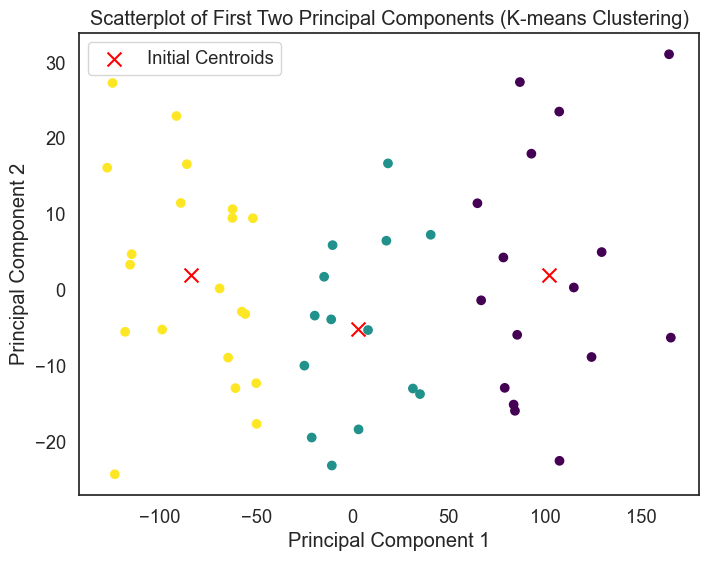

In [97]:
# Compute group means from hierarchical clustering
group_means = pd.DataFrame(PC_scores).groupby(clusters).mean()

# Use group means as initial centroids for K-means clustering
kmeans_US = KMeans(n_clusters=3, init=group_means.values, n_init=1, random_state=5508)
kmeans_US.fit(PC_scores)

# Get the cluster labels from K-means clustering
kmeans_clusters = kmeans_US.labels_

# Plot the scatterplot of the first two principal components with different colors for each K-means cluster
plt.figure(figsize=(8, 6))
plt.scatter(PC_scores[:, 0], PC_scores[:, 1], c=kmeans_clusters, cmap='viridis')
plt.scatter(group_means.iloc[:, 0], group_means.iloc[:, 1], c='red', marker='x', s=100, label='Initial Centroids')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Scatterplot of First Two Principal Components (K-means Clustering)')
plt.legend()
plt.show()

In [98]:
print(PC_scores[:, 0])
print(PC_scores[:, 1])

[  64.80216368   92.82745016  124.06821629   18.34003541  107.42295313
   34.97598596  -60.88728193   66.73102545  165.24437032   40.53517659
 -123.53610577  -51.79700225   78.9920973   -57.55096073 -115.5867897
  -55.78969411  -62.38318061   78.27763132  -89.26104427  129.3301355
  -21.26628263   85.45152667  -98.95481552   86.85635769    7.98628867
  -62.4836353   -69.09654435   83.61357844 -114.7773545   -10.81572512
  114.8681626    84.29423052  164.32551449 -127.49559655  -50.08682167
  -19.6937229   -11.15023958  -64.68914192    3.06397257  107.28106866
  -86.10672005   17.50626427   31.29112174  -49.9133974  -124.71446916
  -14.81744816  -25.07583898  -91.54464698 -118.17632786  -10.43453939]
[ 11.4480074   17.9829427   -8.83040304  16.70391138 -22.52006977
 -13.71958403 -12.93253016  -1.3537978   -6.27469007   7.29023959
 -24.29120791   9.46919099 -12.89706046  -2.84626471   3.3421305
  -3.15723392  10.67327147   4.2949175   11.4878272    5.00703148
 -19.45017903  -5.9045567   

In [133]:
new_features

,incidents_ratio,fatal_accidents_ratio,fatalities_ratio
0,0.333333,1.000000,1.000000
1,0.090909,0.133333,0.689922
2,0.285714,1.000000,1.000000
3,1.500000,0.500000,0.015385
4,1.000000,1.000000,1.000000
5,0.466667,0.600000,4.225000
6,1.666667,1.000000,0.481818
7,1.500000,2.000000,8.000000
8,1.000000,2.000000,89.000000
9,0.625000,0.333333,0.019608


In [134]:
airline_data

,airline,avail_seat_km_per_week,incidents_85_99,fatal_accidents_85_99,fatalities_85_99,incidents_00_14,fatal_accidents_00_14,fatalities_00_14,Cluster
0,Aer Lingus,320906734,2,0,0,0,0,0,1
1,Aeroflot*,1197672318,76,14,128,6,1,88,1
2,Aerolineas Argentinas,385803648,6,0,0,1,0,0,1
3,Aeromexico*,596871813,3,1,64,5,0,0,1
4,Air Canada,1865253802,2,0,0,2,0,0,1
5,Air France,3004002661,14,4,79,6,2,337,2
6,Air India*,869253552,2,1,329,4,1,158,0
7,Air New Zealand*,710174817,3,0,0,5,1,7,1
8,Alaska Airlines*,965346773,5,0,0,5,1,88,1
9,Alitalia,698012498,7,2,50,4,0,0,1


In [144]:
X_US

array([[ 13.2, 236. ,  58. ,  21.2],
       [ 10. , 263. ,  48. ,  44.5],
       [  8.1, 294. ,  80. ,  31. ],
       [  8.8, 190. ,  50. ,  19.5],
       [  9. , 276. ,  91. ,  40.6],
       [  7.9, 204. ,  78. ,  38.7],
       [  3.3, 110. ,  77. ,  11.1],
       [  5.9, 238. ,  72. ,  15.8],
       [ 15.4, 335. ,  80. ,  31.9],
       [ 17.4, 211. ,  60. ,  25.8],
       [  5.3,  46. ,  83. ,  20.2],
       [  2.6, 120. ,  54. ,  14.2],
       [ 10.4, 249. ,  83. ,  24. ],
       [  7.2, 113. ,  65. ,  21. ],
       [  2.2,  56. ,  57. ,  11.3],
       [  6. , 115. ,  66. ,  18. ],
       [  9.7, 109. ,  52. ,  16.3],
       [ 15.4, 249. ,  66. ,  22.2],
       [  2.1,  83. ,  51. ,   7.8],
       [ 11.3, 300. ,  67. ,  27.8],
       [  4.4, 149. ,  85. ,  16.3],
       [ 12.1, 255. ,  74. ,  35.1],
       [  2.7,  72. ,  66. ,  14.9],
       [ 16.1, 259. ,  44. ,  17.1],
       [  9. , 178. ,  70. ,  28.2],
       [  6. , 109. ,  53. ,  16.4],
       [  4.3, 102. ,  62. ,  16.5],
 